In [1]:
# Download base CSVs
import os
import pandas as pd
import requests
import matplotlib.pyplot as plt

# Create data folder path
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

# URLs for open datasets
datasets = {
    "airports": "https://ourairports.com/data/airports.csv",
    "airlines": "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat",
    "routes": "https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat"
}

# Download & save
for name, url in datasets.items():
    file_path = os.path.join(data_dir, f"{name}.csv")
    response = requests.get(url)
    response.raise_for_status()
    with open(file_path, "wb") as f:
        f.write(response.content)
    print(f"Saved {name}.csv")

# Check files exist
os.listdir(data_dir)

Saved airports.csv
Saved airlines.csv
Saved routes.csv


['airlines.csv',
 'airlines_clean.csv',
 'airports.csv',
 'airports_clean.csv',
 'flight_level_base.csv',
 'flight_level_enriched.csv',
 'integrated_routes_final.csv',
 'master_routes_enriched.csv',
 'routes.csv',
 'routes_clean.csv',
 'routes_master.csv',
 'selected_airports.csv']

In [2]:
# Clean + prepare base reference tables
import pandas as pd
import os

# Paths
data_dir = "data"
airports_path = os.path.join(data_dir, "airports.csv")
airlines_path = os.path.join(data_dir, "airlines.csv")
routes_path = os.path.join(data_dir, "routes.csv")

# Load raw files 
airports_raw = pd.read_csv(airports_path)
airlines_raw = pd.read_csv(airlines_path, header=None)
routes_raw = pd.read_csv(routes_path, header=None)

print("Raw shapes:")
print("Airports:", airports_raw.shape)
print("Airlines:", airlines_raw.shape)
print("Routes:", routes_raw.shape)

# Clean airports 
airports = airports_raw[
    ["ident", "type", "name", "iso_country", "municipality", "iata_code", "latitude_deg", "longitude_deg"]
].rename(columns={
    "ident": "Airport_ID",
    "name": "Airport_Name",
    "iso_country": "Country",
    "municipality": "City",
    "iata_code": "IATA_Code",
    "latitude_deg": "Latitude",
    "longitude_deg": "Longitude"
})
airports = airports.dropna(subset=["IATA_Code"])  # keep only airports with IATA codes
airports = airports.reset_index(drop=True)

# Clean airlines 
airlines_raw.columns = [
    "Airline_ID", "Name", "Alias", "IATA", "ICAO", "Callsign", "Country", "Active"
]
airlines = airlines_raw[["Airline_ID", "Name", "IATA", "ICAO", "Country", "Active"]]
airlines = airlines[airlines["Active"] == "Y"]

# Clean routes 
routes_raw.columns = [
    "Airline", "Airline_ID", "Source_Airport", "Source_Airport_ID",
    "Destination_Airport", "Destination_Airport_ID", "Codeshare",
    "Stops", "Equipment"
]
routes = routes_raw[["Airline", "Source_Airport", "Destination_Airport", "Stops"]]

# Save cleaned versions 
airports.to_csv(os.path.join(data_dir, "airports_clean.csv"), index=False)
airlines.to_csv(os.path.join(data_dir, "airlines_clean.csv"), index=False)
routes.to_csv(os.path.join(data_dir, "routes_clean.csv"), index=False)

print("Cleaned files saved in /data as:")
print(os.listdir(data_dir))


Raw shapes:
Airports: (84358, 19)
Airlines: (6162, 8)
Routes: (67663, 9)
Cleaned files saved in /data as:
['airlines.csv', 'airlines_clean.csv', 'airports.csv', 'airports_clean.csv', 'flight_level_base.csv', 'flight_level_enriched.csv', 'integrated_routes_final.csv', 'master_routes_enriched.csv', 'routes.csv', 'routes_clean.csv', 'routes_master.csv', 'selected_airports.csv']


In [3]:
# Filter + Save Indian & Major International Airports
import pandas as pd
import os

data_dir = "data"
airports = pd.read_csv(os.path.join(data_dir, "airports_clean.csv"))

# Filter Indian airports
india_airports = airports[airports["Country"] == "IN"].copy()

# Select major international airports (top 1-2 from major countries)
major_countries = [
    "AE", "SG", "TH", "GB", "US", "DE", "AU", "QA", "OM", "SA", "FR", "MY", "JP", "CN"
]
international_airports = airports[airports["Country"].isin(major_countries)]

# pick only large/medium airports
international_airports = international_airports[
    international_airports["type"].isin(["large_airport", "medium_airport"])
]

# Combine both
selected_airports = pd.concat([india_airports, international_airports]).drop_duplicates(subset=["IATA_Code"])

# Drop any missing IATA codes just in case
selected_airports = selected_airports.dropna(subset=["IATA_Code"]).reset_index(drop=True)

# Save the filtered list
selected_airports.to_csv(os.path.join(data_dir, "selected_airports.csv"), index=False)

print(f"Saved selected_airports.csv with {selected_airports.shape[0]} airports")
print(selected_airports.sample(10))

Saved selected_airports.csv with 1872 airports
     Airport_ID            type                                Airport_Name  \
1529       YCTM  medium_airport                         Cootamundra Airport   
79         VEMH   small_airport                               Malda Airport   
1340       RJFM  medium_airport                            Miyazaki Airport   
353        KBDL   large_airport               Bradley International Airport   
1241       PAFM  medium_airport                              Ambler Airport   
739        KMDT  medium_airport            Harrisburg International Airport   
575        KGLD  medium_airport                  Goodland Municipal Airport   
671        KJLN  medium_airport                     Joplin Regional Airport   
294         HZU  medium_airport                    Chengdu Huaizhou Airport   
443        KCOS  medium_airport  City of Colorado Springs Municipal Airport   

     Country               City IATA_Code   Latitude   Longitude  
1529      AU    

In [4]:
# Generate master route combinations
import pandas as pd
import itertools
import random
import os

data_dir = "data"
airports = pd.read_csv(os.path.join(data_dir, "selected_airports.csv"))

# Split Indian vs international
india_airports = airports[airports["Country"] == "IN"].reset_index(drop=True)
intl_airports = airports[airports["Country"] != "IN"].reset_index(drop=True)

# Generate domestic route pairs
domestic_routes = list(itertools.combinations(india_airports["IATA_Code"], 2))
domestic_df = pd.DataFrame(domestic_routes, columns=["Source_Airport", "Destination_Airport"])
domestic_df["Route_Type"] = "Domestic"

# Generate international route pairs (India ↔ World) ---
intl_routes = []
for src in india_airports["IATA_Code"]:
    # Pick 15 random international airports for each Indian airport
    sample_intl = intl_airports.sample(n=min(15, len(intl_airports)), random_state=random.randint(1, 10000))
    for dest in sample_intl["IATA_Code"]:
        intl_routes.append((src, dest))
        intl_routes.append((dest, src))  # both directions

intl_df = pd.DataFrame(intl_routes, columns=["Source_Airport", "Destination_Airport"])
intl_df["Route_Type"] = "International"

# Combine & remove duplicates
routes_master = pd.concat([domestic_df, intl_df]).drop_duplicates().reset_index(drop=True)

# Save master routes
routes_master.to_csv(os.path.join(data_dir, "routes_master.csv"), index=False)

print(f"Master route map created with {routes_master.shape[0]} unique routes")
print(routes_master.sample(10))

Master route map created with 17710 unique routes
      Source_Airport Destination_Airport     Route_Type
7557             COH                 ZER       Domestic
10260            TEI                 BKB       Domestic
7428             CCU                 GAU       Domestic
273              AYJ                 LUH       Domestic
13976            NAG                 OKD  International
7899             RDP                 VGA       Domestic
15019            TYR                 JRH  International
17697            ONO                 WGC  International
10709            IXD                 CBD       Domestic
1507             RJI                 KQH       Domestic


In [5]:
import os

print("Files in data/:")
print(os.listdir("data"))

Files in data/:
['airlines.csv', 'airlines_clean.csv', 'airports.csv', 'airports_clean.csv', 'flight_level_base.csv', 'flight_level_enriched.csv', 'integrated_routes_final.csv', 'master_routes_enriched.csv', 'routes.csv', 'routes_clean.csv', 'routes_master.csv', 'selected_airports.csv']


In [6]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

# Load required datasets
routes = pd.read_csv("data/routes_master.csv")      # ✅ corrected filename
airports = pd.read_csv("data/selected_airports.csv")

# Prepare lookup for lat/lon 
airport_lookup = airports.set_index("IATA_Code")[["Latitude", "Longitude", "Country"]]

# Merge coordinates for source and destination airports 
routes = routes.merge(airport_lookup, how="left", left_on="Source_Airport", right_index=True)
routes = routes.merge(airport_lookup, how="left", left_on="Destination_Airport", right_index=True, suffixes=("_Source", "_Dest"))

# Haversine distance calculation
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius (km)
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

routes["Distance_km"] = routes.apply(
    lambda x: haversine(x["Latitude_Source"], x["Longitude_Source"], x["Latitude_Dest"], x["Longitude_Dest"])
    if pd.notnull(x["Latitude_Source"]) and pd.notnull(x["Latitude_Dest"]) else np.nan, axis=1
)

# Estimate flight duration (approximation)
def estimate_duration(distance, route_type):
    if pd.isna(distance):
        return np.nan
    avg_speed = 600 if route_type == "Domestic" else 850
    return round(distance / avg_speed, 2)

routes["Est_Duration_hr"] = routes.apply(lambda x: estimate_duration(x["Distance_km"], x["Route_Type"]), axis=1)

# Add region indicators
routes["Source_in_India"] = routes["Country_Source"].apply(lambda c: c == "IN")
routes["Dest_in_India"] = routes["Country_Dest"].apply(lambda c: c == "IN")

# Save enriched master file
routes.to_csv("data/master_routes_enriched.csv", index=False)
print(f"Enriched master route file saved! Shape: {routes.shape}")
routes.head(10)

Enriched master route file saved! Shape: (17710, 13)


,Source_Airport,Destination_Airport,Route_Type,Latitude_Source,Longitude_Source,Country_Source,Latitude_Dest,Longitude_Dest,Country_Dest,Distance_km,Est_Duration_hr,Source_in_India,Dest_in_India
0,PYG,AYJ,Domestic,27.2313,88.587196,IN,26.751283,82.155295,IN,639.451766,1.07,True,True
1,PYG,SDW,Domestic,27.2313,88.587196,IN,16.002552,73.529846,IN,1992.093008,3.32,True,True
2,PYG,NMI,Domestic,27.2313,88.587196,IN,18.984597,73.065253,IN,1830.803835,3.05,True,True
3,PYG,RQY,Domestic,27.2313,88.587196,IN,13.858024,75.618868,IN,2005.450340,3.34,True,True
4,PYG,HGI,Domestic,27.2313,88.587196,IN,26.966830,93.638792,IN,500.876878,0.83,True,True
5,PYG,UKE,Domestic,27.2313,88.587196,IN,20.097778,83.183333,IN,965.101706,1.61,True,True
6,PYG,AHA,Domestic,27.2313,88.587196,IN,22.987530,83.196120,IN,719.066690,1.20,True,True
7,PYG,JGB,Domestic,27.2313,88.587196,IN,19.074301,82.036797,IN,1126.915347,1.88,True,True
8,PYG,RJI,Domestic,27.2313,88.587196,IN,33.377899,74.315201,IN,1529.127963,2.55,True,True
9,PYG,REW,Domestic,27.2313,88.587196,IN,24.503401,81.220299,IN,796.861104,1.33,True,True


In [7]:
# Route Insights Summary
import pandas as pd

routes = pd.read_csv("data/master_routes_enriched.csv")

# Longest & Shortest Domestic Routes 
domestic = routes[routes["Route_Type"] == "Domestic"].copy()
international = routes[routes["Route_Type"] == "International"].copy()

print("Top 10 Longest Domestic Routes:")
display(domestic.nlargest(10, "Distance_km")[["Source_Airport", "Destination_Airport", "Distance_km", "Est_Duration_hr"]])

print("\nTop 10 Shortest Domestic Routes:")
display(domestic.nsmallest(10, "Distance_km")[["Source_Airport", "Destination_Airport", "Distance_km", "Est_Duration_hr"]])

# Longest & Shortest International Routes 
print("\nTop 10 Longest International Routes:")
display(international.nlargest(10, "Distance_km")[["Source_Airport", "Destination_Airport", "Distance_km", "Est_Duration_hr"]])

print("\nTop 10 Shortest International Routes:")
display(international.nsmallest(10, "Distance_km")[["Source_Airport", "Destination_Airport", "Distance_km", "Est_Duration_hr"]])

# Summary Stats
summary = routes.groupby("Route_Type")[["Distance_km", "Est_Duration_hr"]].mean().round(2)
print("\nAverage Distance & Duration by Route Type:")
display(summary)

Top 10 Longest Domestic Routes:


,Source_Airport,Destination_Airport,Distance_km,Est_Duration_hr
12188,SXR,CBD,3320.038718,5.53
1529,RJI,CBD,3293.621417,5.49
11726,IXJ,CBD,3203.451121,5.34
11908,IXL,CBD,3185.612731,5.31
10289,TEI,AGX,3140.572805,5.23
10774,ATQ,CBD,3122.307092,5.20
12034,IXP,CBD,3117.189347,5.20
9919,IXT,AGX,3082.591100,5.14
12202,SXR,IXZ,3080.655769,5.13
11423,DHM,CBD,3074.873984,5.12



Top 10 Shortest Domestic Routes:


,Source_Airport,Destination_Airport,Distance_km,Est_Duration_hr
9054,IXQ,IXN,22.489719,0.04
489,NMI,BOM,23.755901,0.04
12649,HYD,BPM,24.984294,0.04
12332,BEP,VDY,26.844825,0.04
3715,HSR,RAJ,27.827106,0.05
9052,IXQ,IXH,27.829673,0.05
11284,DEL,HDO,30.795471,0.05
1668,REW,TNI,37.740935,0.06
12581,GOX,GOI,40.535655,0.07
6690,IXA,IXN,41.739373,0.07



Top 10 Longest International Routes:


,Source_Airport,Destination_Airport,Distance_km,Est_Duration_hr
17350,IXZ,TMB,15803.132314,18.59
17351,TMB,IXZ,15803.132314,18.59
16664,AGX,BRO,15778.694620,18.56
16665,BRO,AGX,15778.694620,18.56
16950,CBD,CRP,15761.764536,18.54
16951,CRP,CBD,15761.764536,18.54
17320,NVY,ALI,15631.209413,18.39
17321,ALI,NVY,15631.209413,18.39
13004,RQY,NGP,15332.075047,18.04
13005,NGP,RQY,15332.075047,18.04



Top 10 Shortest International Routes:


,Source_Airport,Destination_Airport,Distance_km,Est_Duration_hr
14350,IXA,LXA,602.560505,0.71
14351,LXA,IXA,602.560505,0.71
15216,AJL,LJG,829.149274,0.98
15217,LJG,AJL,829.149274,0.98
14468,SHL,DLU,835.705883,0.98
14469,DLU,SHL,835.705883,0.98
15104,IXH,LJG,867.665869,1.02
15105,LJG,IXH,867.665869,1.02
14848,GAU,DCY,907.058496,1.07
14849,DCY,GAU,907.058496,1.07



Average Distance & Duration by Route Type:


,Distance_km,Est_Duration_hr
Route_Type,,
Domestic,1218.70,2.03
International,9239.51,10.87


In [8]:
# Load Clean Datasets
import pandas as pd

# File paths
path = "./data/"
airlines = pd.read_csv(path + "airlines_clean.csv")
airports = pd.read_csv(path + "airports_clean.csv")
routes = pd.read_csv(path + "routes_master.csv")

print("Data Loaded Successfully!\n")
print(f"Airlines: {airlines.shape}")
print(f"Airports: {airports.shape}")
print(f"Routes: {routes.shape}")

display(airlines.head(2))
display(airports.head(2))
display(routes.head(2))

Data Loaded Successfully!

Airlines: (1255, 6)
Airports: (9060, 8)
Routes: (17710, 3)


,Airline_ID,Name,IATA,ICAO,Country,Active
0,-1,Unknown,-,NaN,\N,Y
1,1,Private flight,-,NaN,NaN,Y


,Airport_ID,type,Airport_Name,Country,City,IATA_Code,Latitude,Longitude
0,03N,small_airport,Utirik Airport,MH,Utirik Island,UTK,11.222219,169.851429
1,07FA,small_airport,Ocean Reef Club Airport,US,Key Largo,OCA,25.325399,-80.274803


,Source_Airport,Destination_Airport,Route_Type
0,PYG,AYJ,Domestic
1,PYG,SDW,Domestic


In [9]:
print("Airlines columns:", airlines.columns.tolist())
print("Routes columns:", routes.columns.tolist())

Airlines columns: ['Airline_ID', 'Name', 'IATA', 'ICAO', 'Country', 'Active']
Routes columns: ['Source_Airport', 'Destination_Airport', 'Route_Type']


In [10]:
# Derived Metrics & Export

import pandas as pd

# Load enriched routes file
path = "data/"
routes_enriched = pd.read_csv(path + "master_routes_enriched.csv")

# Source/Destination frequency
source_freq = routes_enriched["Source_Airport"].value_counts().reset_index(name="Source_Flight_Frequency").rename(columns={"index": "Source_Airport"})
dest_freq = routes_enriched["Destination_Airport"].value_counts().reset_index(name="Destination_Flight_Frequency").rename(columns={"index": "Destination_Airport"})

# Merge frequencies
routes_final = routes_enriched.merge(source_freq, on="Source_Airport", how="left")
routes_final = routes_final.merge(dest_freq, on="Destination_Airport", how="left")

# Region pair
routes_final["Region_Pair"] = routes_final["Country_Source"] + " → " + routes_final["Country_Dest"]

# Save final integrated dataset
output_path = path + "integrated_routes_final.csv"
routes_final.to_csv(output_path, index=False)

print(f"Final integrated dataset saved as {output_path}")
print(f"Final shape: {routes_final.shape}")

routes_final.head(3)

Final integrated dataset saved as data/integrated_routes_final.csv
Final shape: (17710, 16)


,Source_Airport,Destination_Airport,Route_Type,Latitude_Source,Longitude_Source,Country_Source,Latitude_Dest,Longitude_Dest,Country_Dest,Distance_km,Est_Duration_hr,Source_in_India,Dest_in_India,Source_Flight_Frequency,Destination_Flight_Frequency,Region_Pair
0,PYG,AYJ,Domestic,27.2313,88.587196,IN,26.751283,82.155295,IN,639.451766,1.07,True,True,175,16,IN → IN
1,PYG,SDW,Domestic,27.2313,88.587196,IN,16.002552,73.529846,IN,1992.093008,3.32,True,True,175,17,IN → IN
2,PYG,NMI,Domestic,27.2313,88.587196,IN,18.984597,73.065253,IN,1830.803835,3.05,True,True,175,18,IN → IN


In [11]:
import pandas as pd

path = "data/"
df = pd.read_csv(path + "integrated_routes_final.csv")

print("integrated_routes_final.csv — Columns:\n")
print(df.columns.tolist())
print("\nShape:", df.shape)
df.head(3)

integrated_routes_final.csv — Columns:

['Source_Airport', 'Destination_Airport', 'Route_Type', 'Latitude_Source', 'Longitude_Source', 'Country_Source', 'Latitude_Dest', 'Longitude_Dest', 'Country_Dest', 'Distance_km', 'Est_Duration_hr', 'Source_in_India', 'Dest_in_India', 'Source_Flight_Frequency', 'Destination_Flight_Frequency', 'Region_Pair']

Shape: (17710, 16)


,Source_Airport,Destination_Airport,Route_Type,Latitude_Source,Longitude_Source,Country_Source,Latitude_Dest,Longitude_Dest,Country_Dest,Distance_km,Est_Duration_hr,Source_in_India,Dest_in_India,Source_Flight_Frequency,Destination_Flight_Frequency,Region_Pair
0,PYG,AYJ,Domestic,27.2313,88.587196,IN,26.751283,82.155295,IN,639.451766,1.07,True,True,175,16,IN → IN
1,PYG,SDW,Domestic,27.2313,88.587196,IN,16.002552,73.529846,IN,1992.093008,3.32,True,True,175,17,IN → IN
2,PYG,NMI,Domestic,27.2313,88.587196,IN,18.984597,73.065253,IN,1830.803835,3.05,True,True,175,18,IN → IN


In [12]:
# Generate Realistic Flight-Level Data for 2024–2025
import pandas as pd
import numpy as np
import random

path = "data/"
routes = pd.read_csv(path + "integrated_routes_final.csv")

np.random.seed(42)
random.seed(42)

# Airlines (realistic Indian + global mix)
airlines = [
    ("IndiGo", "6E"), ("Air India", "AI"), ("Vistara", "UK"),
    ("SpiceJet", "SG"), ("AirAsia India", "I5"), ("Akasa Air", "QP"),
    ("Emirates", "EK"), ("Qatar Airways", "QR"), ("Singapore Airlines", "SQ"),
    ("Lufthansa", "LH")
]

years = [2024, 2025]

flights_list = []

# Adjust flight generation frequency (higher for domestic)
for _, row in routes.iterrows():
    for year in years:
        # Domestic: 3–5 flights per route per year; International: 2–4
        n_flights = np.random.randint(3, 6) if row["Route_Type"] == "Domestic" else np.random.randint(2, 5)

        for _ in range(n_flights):
            airline_name, airline_code = random.choice(airlines)
            date = pd.Timestamp(year, random.randint(1, 12), random.randint(1, 28))
            flight_number = f"{airline_code}{random.randint(100, 999)}"

            dep_hour = random.randint(0, 23)
            dep_minute = random.choice([0, 15, 30, 45])
            dep_time = f"{dep_hour:02d}:{dep_minute:02d}"

            duration_min = int(row["Est_Duration_hr"] * 60)
            arr_time = pd.Timestamp(year, 1, 1, dep_hour, dep_minute) + pd.Timedelta(minutes=duration_min)
            arr_time = f"{arr_time.hour:02d}:{arr_time.minute:02d}"

            flights_list.append([
                airline_name, airline_code, flight_number, str(date.date()), year,
                date.month, date.day_name(), row["Source_Airport"], row["Destination_Airport"],
                row["Route_Type"], row["Distance_km"], duration_min, dep_time, arr_time,
                row["Country_Source"], row["Country_Dest"], row["Region_Pair"]
            ])

# Convert to DataFrame
flights = pd.DataFrame(flights_list, columns=[
    "Airline_Name", "Airline_Code", "Flight_Number", "Date", "Year", "Month", "Day_of_Week",
    "Source_Airport", "Destination_Airport", "Route_Type", "Distance_km", "Flight_Duration_min",
    "Departure_Time", "Arrival_Time", "Country_Source", "Country_Dest", "Region_Pair"
])

# Add unique flight ID
flights["Flight_ID"] = [f"F{i:06d}" for i in range(1, len(flights) + 1)]
flights = flights[[
    "Flight_ID", "Flight_Number", "Airline_Name", "Airline_Code", "Date", "Year", "Month",
    "Day_of_Week", "Source_Airport", "Destination_Airport", "Route_Type", "Distance_km",
    "Flight_Duration_min", "Departure_Time", "Arrival_Time", "Country_Source",
    "Country_Dest", "Region_Pair"
]]

# Save
output_path = path + "flight_level_base.csv"
flights.to_csv(output_path, index=False)

print(f"Total flights to generate: {len(flights)}")
print(f"  • 2024: {(flights['Year'] == 2024).sum()}")
print(f"  • 2025: {(flights['Year'] == 2025).sum()}")
print(f"\nFlight-level dataset created with shape: {flights.shape}")
print(f"  Years covered: {flights['Year'].unique()}")
print(f"  Airlines used: {len(set(flights['Airline_Name']))} airlines")

Total flights to generate: 131806
  • 2024: 65974
  • 2025: 65832

Flight-level dataset created with shape: (131806, 18)
  Years covered: [2024 2025]
  Airlines used: 10 airlines


In [13]:
# Add delays, cancellations, fares, performance scores
import pandas as pd
import numpy as np
import random

path = "data/"
flights = pd.read_csv(path + "flight_level_base.csv")

np.random.seed(2025)
random.seed(2025)

# Helpers 
def time_bin(hhmm):
    h, m = map(int, hhmm.split(":"))
    if 5 <= h < 11:
        return "Morning"
    if 11 <= h < 15:
        return "Noon"
    if 15 <= h < 21:
        return "Evening"
    return "Night"

def categorize_delay(mins):
    if pd.isna(mins):
        return "Cancelled"
    if mins <= 15:
        return "On Time"
    if mins <= 60:
        return "Minor"
    if mins <= 180:
        return "Major"
    return "Very Major"

# Airline reliability baseline (lower means better, in minutes)
airline_bias = {
    "IndiGo": 5, "Air India": 12, "Vistara": 6, "SpiceJet": 18, "AirAsia India": 10,
    "Akasa Air": 11, "Emirates": 6, "Qatar Airways": 5, "Singapore Airlines": 4, "Lufthansa": 6
}

# If any airline not found, default bias
default_airline_bias = 10

# Determine airport congestion from flight counts (higher -> small multiplier to delay)
src_counts = flights["Source_Airport"].value_counts().to_dict()
dst_counts = flights["Destination_Airport"].value_counts().to_dict()

def congestion_factor(src, dst):
    # Normalize counts roughly and combine
    s = src_counts.get(src, 1)
    d = dst_counts.get(dst, 1)
    # scale: low(1) -> factor ~0.9, medium ->1.0, high -> up to 1.25
    score = (s + d) / (np.mean(list(src_counts.values())) * 2)
    return np.clip(0.85 + score * 0.7, 0.85, 1.4)

# Seasons / monsoon months for India (Jun-Sep)
monsoon_months = {6,7,8,9}

# Convert Date to datetime if not already
flights["Date"] = pd.to_datetime(flights["Date"])

# Derived time bins
flights["Departure_Time_Bin"] = flights["Departure_Time"].apply(time_bin)

# Pre-allocate columns
n = len(flights)
flights["Departure_Delay_min"] = 0
flights["Arrival_Delay_min"] = 0
flights["Total_Delay_min"] = 0
flights["Cancelled"] = 0
flights["Cancellation_Reason"] = ""
flights["Fare_Type"] = ""
flights["Base_Fare_INR"] = 0
flights["Tax_INR"] = 0
flights["Ticket_Price_INR"] = 0
flights["On_Time"] = 0
flights["Delay_Category"] = ""
flights["Flight_Performance_Score"] = 0.0

# Fare type probabilities
fare_type_probs = {"Economy": 0.88, "PremiumEconomy": 0.05, "Business": 0.07}

# Cancellation reasons
cancel_reasons = ["Weather", "Technical Issue", "Crew Shortage", "Air Traffic", "Operational"]

# Loop in vectorized-ish batches for performance
for idx, row in flights.iterrows():
    route_type = row["Route_Type"]
    month = row["Date"].month
    src = row["Source_Airport"]
    dst = row["Destination_Airport"]
    dist = float(row["Distance_km"]) if not pd.isna(row["Distance_km"]) else 500.0

    # airline bias
    airline = row.get("Airline_Name", None)
    bias = airline_bias.get(airline, default_airline_bias)

    # congestion multiplier
    cong = congestion_factor(src, dst)

    # time-of-day multiplier
    bin_ = row["Departure_Time_Bin"]
    tod_mult = {"Morning": 1.0, "Noon": 0.98, "Evening": 1.08, "Night": 1.02}[bin_]

    # seasonal/monsoon penalty if either airport in India and month in monsoon months
    india_leg = (row["Country_Source"] == "IN") or (row["Country_Dest"] == "IN")
    monsoon_penalty = 1.25 if (india_leg and month in monsoon_months) else 1.0

    # base departure delay distribution:
    # Domestic: mean ~ bias + small base; International: slightly larger means
    if route_type == "Domestic":
        dep_mean = bias * 0.9 + 8  # baseline + airline bias
        dep_std = max(6, dep_mean * 0.6)
    else:
        dep_mean = bias * 1.1 + 15
        dep_std = max(10, dep_mean * 0.6)

    # final mean after multipliers
    dep_mean = dep_mean * cong * tod_mult * monsoon_penalty
    dep_delay = int(np.random.normal(dep_mean, dep_std))
    dep_delay = max(0, dep_delay)  # no negative departure delays

    # Arrival delay: departure delay + in-flight variance depending on distance
    inflight_std = 5 + (dist / 1000.0) * 8  # longer flights -> more variance
    arr_delay = int(np.random.normal(dep_delay * 0.9, inflight_std))
    arr_delay = max(0, arr_delay)

    # Cancellation probability: base + weather/monsoon bump + low reliability airlines bump
    base_cancel = 0.005 if route_type == "Domestic" else 0.012
    airline_penalty = 0.003 if airline in ["SpiceJet", "AirAsia India"] else 0.0
    monsoon_cancel_bump = 0.01 if (india_leg and month in monsoon_months) else 0.0
    cong_cancel_bump = min(0.01, (cong - 1.0) * 0.02)  # small bump if heavily congested
    cancel_prob = base_cancel + airline_penalty + monsoon_cancel_bump + cong_cancel_bump
    cancelled = np.random.random() < cancel_prob

    # If cancelled, set delays NA/0 and choose reason
    if cancelled:
        flights.at[idx, "Cancelled"] = 1
        flights.at[idx, "Cancellation_Reason"] = random.choice(cancel_reasons)
        flights.at[idx, "Departure_Delay_min"] = np.nan
        flights.at[idx, "Arrival_Delay_min"] = np.nan
        flights.at[idx, "Total_Delay_min"] = np.nan
        flights.at[idx, "Delay_Category"] = "Cancelled"
        flights.at[idx, "On_Time"] = 0
        flights.at[idx, "Flight_Performance_Score"] = 0.0
        continue

    # Not cancelled -> assign delays
    flights.at[idx, "Departure_Delay_min"] = int(dep_delay)
    flights.at[idx, "Arrival_Delay_min"] = int(arr_delay)

    # Total delay prefer arrival delay as per your spec
    total_delay = int(arr_delay)
    flights.at[idx, "Total_Delay_min"] = total_delay

    # On time boolean
    flights.at[idx, "On_Time"] = 1 if total_delay <= 15 else 0

    # Delay category
    flights.at[idx, "Delay_Category"] = categorize_delay(total_delay)

    # Flight performance score (10 = perfect). Heavier penalty for larger delays.
    # score = 10 - normalized penalty where 60 min = -2, 180 min = -6
    score = 10 - (min(total_delay, 240) / 60) * 2.0
    # account for airline reliability: better airlines get small bonus
    score += (8 - bias) * 0.03  # small tweak
    flights.at[idx, "Flight_Performance_Score"] = round(max(0.5, min(10.0, score)), 2)

    # Fare logic 
    # Base fare tiers (INR per km multipliers) more realistic:
    if route_type == "Domestic":
        # base price per km with smoothing and a minimal base fare
        base_per_km = np.random.uniform(1.8, 3.0)  # INR per km
        base_fare = max(1200, int(dist * base_per_km))
        # seasonal premium (festive months Oct-Nov & Dec) slightly higher
        if month in {10, 11, 12}:
            base_fare = int(base_fare * 1.12)
    else:
        base_per_km = np.random.uniform(4.0, 8.0)
        base_fare = max(8000, int(dist * base_per_km))
        if month in {11, 12}:  # holiday season
            base_fare = int(base_fare * 1.08)

    # fare type selection
    r = np.random.random()
    if r < fare_type_probs["Economy"]:
        fare_type = "Economy"
        multiplier = 1.0
    elif r < fare_type_probs["Economy"] + fare_type_probs["PremiumEconomy"]:
        fare_type = "PremiumEconomy"
        multiplier = 1.6
    else:
        fare_type = "Business"
        multiplier = 3.6

    actual_base = int(base_fare * multiplier)
    tax_pct = np.random.uniform(0.05, 0.18) if route_type == "Domestic" else np.random.uniform(0.12, 0.28)
    tax_amt = int(actual_base * tax_pct)
    ticket_price = actual_base + tax_amt

    flights.at[idx, "Fare_Type"] = fare_type
    flights.at[idx, "Base_Fare_INR"] = actual_base
    flights.at[idx, "Tax_INR"] = tax_amt
    flights.at[idx, "Ticket_Price_INR"] = ticket_price

# End loop

# Clean types and finalize
# For cancelled rows, ensure numeric NaN are preserved
flights["Departure_Delay_min"] = pd.to_numeric(flights["Departure_Delay_min"], errors="coerce")
flights["Arrival_Delay_min"] = pd.to_numeric(flights["Arrival_Delay_min"], errors="coerce")
flights["Total_Delay_min"] = pd.to_numeric(flights["Total_Delay_min"], errors="coerce")
flights["Cancelled"] = flights["Cancelled"].astype(int)
flights["On_Time"] = flights["On_Time"].astype(int)
flights["Flight_Performance_Score"] = flights["Flight_Performance_Score"].round(2)

# Save enriched dataset
out = path + "flight_level_enriched.csv"
flights.to_csv(out, index=False)

print(f"Highly-realistic enriched flights saved to: {out}")
print("Shape:", flights.shape)
print("\nSample rows:")
display(flights.sample(6).T)

Highly-realistic enriched flights saved to: data/flight_level_enriched.csv
Shape: (131806, 31)

Sample rows:


,62570,34080,17173,88324,74919,1770
Flight_ID,F062571,F034081,F017174,F088325,F074920,F001771
Flight_Number,SQ646,SG686,UK410,6E510,SG798,SQ301
Airline_Name,Singapore Airlines,SpiceJet,Vistara,IndiGo,SpiceJet,Singapore Airlines
Airline_Code,SQ,SG,UK,6E,SG,SQ
Date,2025-12-03 00:00:00,2024-03-18 00:00:00,2024-10-03 00:00:00,2024-08-25 00:00:00,2025-08-04 00:00:00,2024-04-11 00:00:00
Year,2025,2024,2024,2024,2025,2024
Month,12,3,10,8,8,4
Day_of_Week,Wednesday,Monday,Thursday,Sunday,Monday,Thursday
Source_Airport,RDP,JGA,AKD,BEK,IXN,AYJ
Destination_Airport,KBK,GAU,HSR,DEL,MYQ,DGH


In [14]:
import os
import pandas as pd

# Path to data folder
data_path = "data/"

# List all files in the folder
files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
print(f"CSV Files found: {files}\n")

# Loop through each file
for file in files:
    print(f"--- {file} ---")
    df = pd.read_csv(os.path.join(data_path, file))
    
    # Shape
    print(f"Shape: {df.shape}")
    
    # Check for any null values
    null_count = df.isnull().sum().sum()
    print(f"Total Null Values: {null_count}")
    
    # Check for any fully empty columns
    empty_cols = [col for col in df.columns if df[col].isnull().all()]
    print(f"Fully Empty Columns: {empty_cols if empty_cols else 'None'}")
    
    # Optional: show first 2 rows
    print(df.head(2))
    print("\n")

CSV Files found: ['airlines.csv', 'airlines_clean.csv', 'airports.csv', 'airports_clean.csv', 'flight_level_base.csv', 'flight_level_enriched.csv', 'integrated_routes_final.csv', 'master_routes_enriched.csv', 'routes.csv', 'routes_clean.csv', 'routes_master.csv', 'selected_airports.csv']

--- airlines.csv ---
Shape: (6161, 8)
Total Null Values: 6042
Fully Empty Columns: None
   -1         Unknown  \N    -  N/A     \N.1           \N.2  Y
0   1  Private flight  \N    -  NaN      NaN            NaN  Y
1   2     135 Airways  \N  NaN  GNL  GENERAL  United States  N


--- airlines_clean.csv ---
Shape: (1255, 6)
Total Null Values: 271
Fully Empty Columns: None
   Airline_ID            Name IATA ICAO Country Active
0          -1         Unknown    -  NaN      \N      Y
1           1  Private flight    -  NaN     NaN      Y


--- airports.csv ---
Shape: (84358, 19)
Total Null Values: 509614
Fully Empty Columns: None
       id ident           type                  name  latitude_deg  \
0    6523

In [15]:
import pandas as pd

# Load enriched flight-level data
path = "data/"
flights = pd.read_csv(path + "flight_level_enriched.csv")

# Check null values per column
null_counts = flights.isnull().sum()

# Filter only columns with at least 1 null
null_columns = null_counts[null_counts > 0].sort_values(ascending=False)

print("Columns with null values and counts:\n")
print(null_columns)

Columns with null values and counts:

Cancellation_Reason    129315
Departure_Delay_min      2491
Arrival_Delay_min        2491
Total_Delay_min          2491
Fare_Type                2491
dtype: int64


In [16]:
import pandas as pd

# Load flight-level enriched dataset
path = "data/flight_level_enriched.csv"
flights = pd.read_csv(path)

# Basic overview
print("Shape:", flights.shape)
print("\nColumns:\n", flights.columns)
print("\nNull values per column:\n", flights.isnull().sum())
print("\nData types:\n", flights.dtypes)
flights.head()

Shape: (131806, 31)

Columns:
 Index(['Flight_ID', 'Flight_Number', 'Airline_Name', 'Airline_Code', 'Date',
       'Year', 'Month', 'Day_of_Week', 'Source_Airport', 'Destination_Airport',
       'Route_Type', 'Distance_km', 'Flight_Duration_min', 'Departure_Time',
       'Arrival_Time', 'Country_Source', 'Country_Dest', 'Region_Pair',
       'Departure_Time_Bin', 'Departure_Delay_min', 'Arrival_Delay_min',
       'Total_Delay_min', 'Cancelled', 'Cancellation_Reason', 'Fare_Type',
       'Base_Fare_INR', 'Tax_INR', 'Ticket_Price_INR', 'On_Time',
       'Delay_Category', 'Flight_Performance_Score'],
      dtype='object')

Null values per column:
 Flight_ID                        0
Flight_Number                    0
Airline_Name                     0
Airline_Code                     0
Date                             0
Year                             0
Month                            0
Day_of_Week                      0
Source_Airport                   0
Destination_Airport             

,Flight_ID,Flight_Number,Airline_Name,Airline_Code,Date,Year,Month,Day_of_Week,Source_Airport,Destination_Airport,...,Total_Delay_min,Cancelled,Cancellation_Reason,Fare_Type,Base_Fare_INR,Tax_INR,Ticket_Price_INR,On_Time,Delay_Category,Flight_Performance_Score
0,F000001,AI381,Air India,AI,2024-01-24,2024,1,Wednesday,PYG,AYJ,...,29.0,0,NaN,Economy,1348,153,1501,0,Minor,8.91
1,F000002,UK792,Vistara,UK,2024-12-04,2024,12,Wednesday,PYG,AYJ,...,24.0,0,NaN,Economy,1949,171,2120,0,Minor,9.26
2,F000003,LH130,Lufthansa,LH,2024-07-02,2024,7,Tuesday,PYG,AYJ,...,29.0,0,NaN,Economy,1341,239,1580,0,Minor,9.09
3,F000004,SG127,SpiceJet,SG,2024-09-20,2024,9,Friday,PYG,AYJ,...,26.0,0,NaN,Economy,1877,220,2097,0,Minor,8.83
4,F000005,SQ559,Singapore Airlines,SQ,2024-07-08,2024,7,Monday,PYG,AYJ,...,26.0,0,NaN,Economy,1369,204,1573,0,Minor,9.25


In [17]:
# Summary of numeric columns
flights.describe()

# Count of unique values for key categorical columns
categorical_cols = ["Airline_Name", "Route_Type", "Source_Airport", "Destination_Airport", "Month", "Day_of_Week"]
for col in categorical_cols:
    print(f"\nUnique values in {col}: {flights[col].nunique()}")
    print(flights[col].value_counts().head(10))


Unique values in Airline_Name: 10
Airline_Name
Emirates              13309
AirAsia India         13257
Singapore Airlines    13240
Vistara               13232
Air India             13230
Lufthansa             13202
SpiceJet              13130
Akasa Air             13078
Qatar Airways         13077
IndiGo                13051
Name: count, dtype: int64

Unique values in Route_Type: 2
Route_Type
Domestic         102948
International     28858
Name: count, dtype: int64

Unique values in Source_Airport: 1428
Source_Airport
PYG    1374
SDW    1349
NMI    1346
AYJ    1340
RQY    1339
UKE    1319
HGI    1317
REW    1297
JGB    1293
RJI    1289
Name: count, dtype: int64

Unique values in Destination_Airport: 1428
Destination_Airport
WGC    1374
TRZ    1367
TRV    1353
TIR    1340
TJV    1338
TCR    1338
RJA    1323
SXV    1320
RMD    1313
PNY    1303
Name: count, dtype: int64

Unique values in Month: 12
Month
11    11124
8     11101
12    11096
5     11072
6     11016
2     10980
3     10961
1

In [18]:
flights.groupby("Airline_Name").size().sort_values(ascending=False)

Airline_Name
Emirates              13309
AirAsia India         13257
Singapore Airlines    13240
Vistara               13232
Air India             13230
Lufthansa             13202
SpiceJet              13130
Akasa Air             13078
Qatar Airways         13077
IndiGo                13051
dtype: int64

C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\3682553989.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=flights_per_airline.values, y=flights_per_airline.index, palette="viridis")


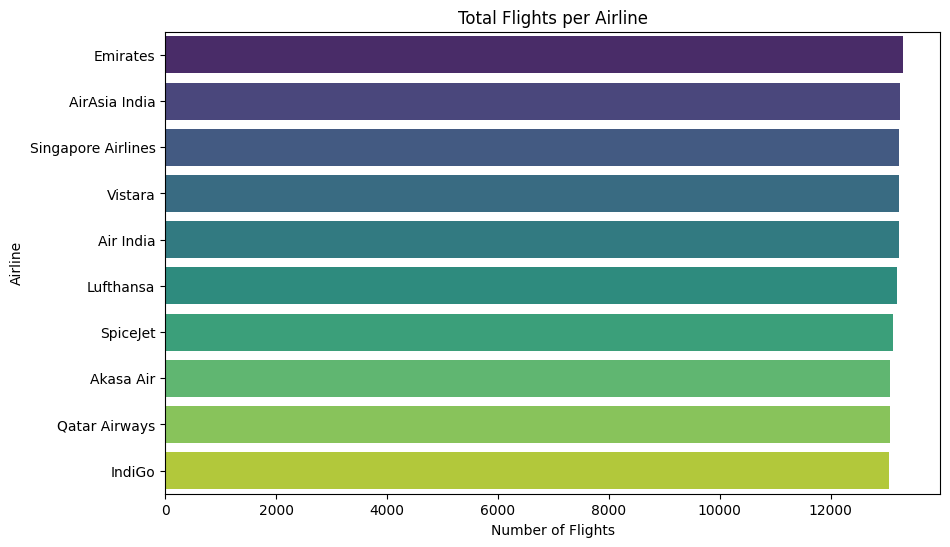

In [19]:
# Flights per Airline
import seaborn as sns
flights_per_airline = flights["Airline_Name"].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=flights_per_airline.values, y=flights_per_airline.index, palette="viridis")
plt.title("Total Flights per Airline")
plt.xlabel("Number of Flights")
plt.ylabel("Airline")
plt.show()

In [20]:
flights.groupby("Month").size()
flights.groupby("Day_of_Week").size()


Day_of_Week
Friday       18676
Monday       18902
Saturday     18865
Sunday       18861
Thursday     18817
Tuesday      18827
Wednesday    18858
dtype: int64

C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\3856552151.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=flights_per_month.index, y=flights_per_month.values, palette="magma")


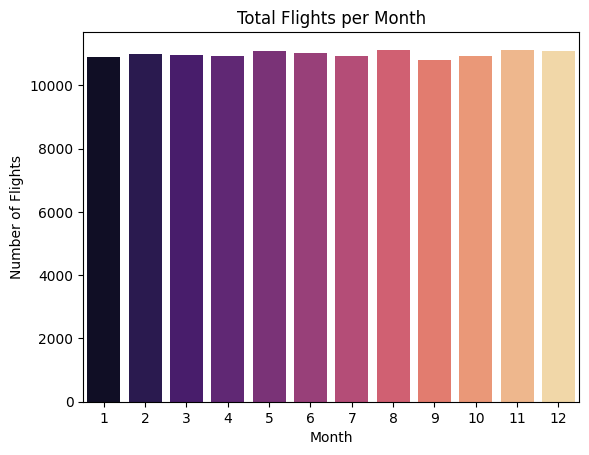

In [21]:
# Ensure Date is datetime
flights["Date"] = pd.to_datetime(flights["Date"])
flights["Month"] = flights["Date"].dt.month

# Flights per month
flights_per_month = flights["Month"].value_counts().sort_index()

# Plot
sns.barplot(x=flights_per_month.index, y=flights_per_month.values, palette="magma")
plt.title("Total Flights per Month")
plt.xlabel("Month")
plt.ylabel("Number of Flights")
plt.show()


C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\759892312.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=flights_per_day.index, y=flights_per_day.values, palette="coolwarm")


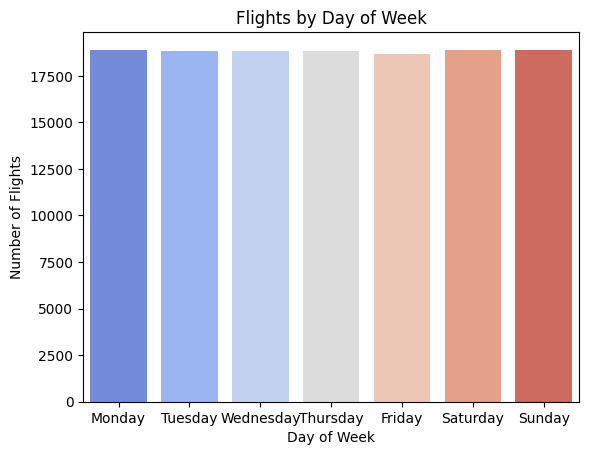

In [22]:
flights_per_day = flights["Day_of_Week"].value_counts().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

sns.barplot(x=flights_per_day.index, y=flights_per_day.values, palette="coolwarm")
plt.title("Flights by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Flights")
plt.show()


In [23]:
flights["Route_Type"].value_counts()


Route_Type
Domestic         102948
International     28858
Name: count, dtype: int64

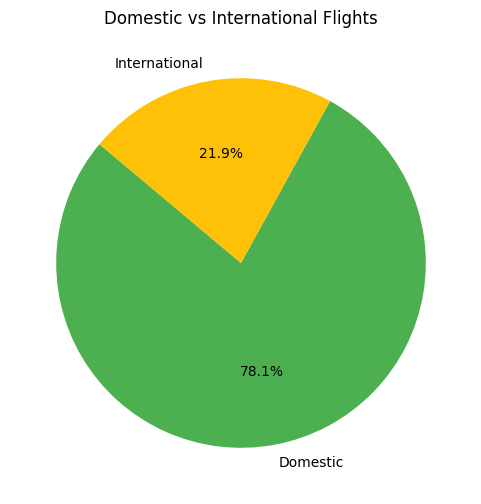

In [24]:
# Route Type Breakdown using Matplotlib
route_counts = flights["Route_Type"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(route_counts, labels=route_counts.index, autopct='%1.1f%%', startangle=140, colors=["#4CAF50", "#FFC107"])
plt.title("Domestic vs International Flights")
plt.show()


C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\3022543014.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_routes.values, y=top_routes.index, palette="cubehelix")


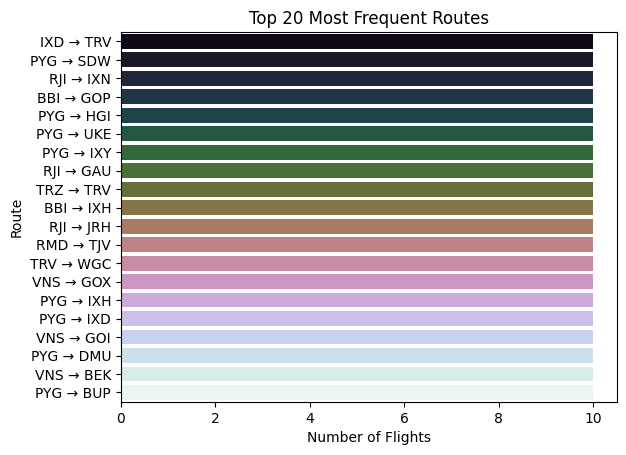

In [25]:
flights["Route"] = flights["Source_Airport"] + " → " + flights["Destination_Airport"]
top_routes = flights["Route"].value_counts().head(20)

sns.barplot(x=top_routes.values, y=top_routes.index, palette="cubehelix")
plt.title("Top 20 Most Frequent Routes")
plt.xlabel("Number of Flights")
plt.ylabel("Route")
plt.show()


In [26]:
flights.groupby("Airline_Name")[["Departure_Delay_min","Arrival_Delay_min","Total_Delay_min"]].mean().sort_values(by="Total_Delay_min", ascending=False)


,Departure_Delay_min,Arrival_Delay_min,Total_Delay_min
Airline_Name,,,
SpiceJet,40.586623,39.746321,39.746321
Air India,31.710281,32.532075,32.532075
Akasa Air,30.346354,31.237180,31.237180
AirAsia India,28.936251,30.148568,30.148568
Vistara,23.116274,25.936354,25.936354
Lufthansa,23.143298,25.583989,25.583989
Emirates,23.055887,25.231205,25.231205
Qatar Airways,21.542147,24.636491,24.636491
IndiGo,21.534218,24.585954,24.585954


C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\3768730387.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_delay_airline.values, y=avg_delay_airline.index, palette="cool")


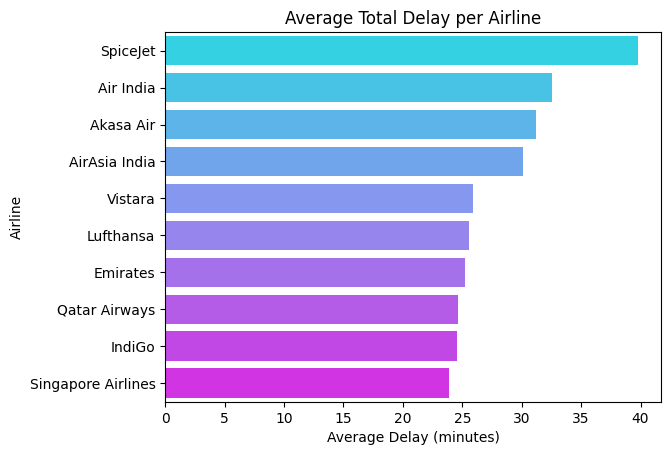

In [27]:
avg_delay_airline = flights.groupby("Airline_Name")["Total_Delay_min"].mean().sort_values(ascending=False)

sns.barplot(x=avg_delay_airline.values, y=avg_delay_airline.index, palette="cool")
plt.title("Average Total Delay per Airline")
plt.xlabel("Average Delay (minutes)")
plt.ylabel("Airline")
plt.show()


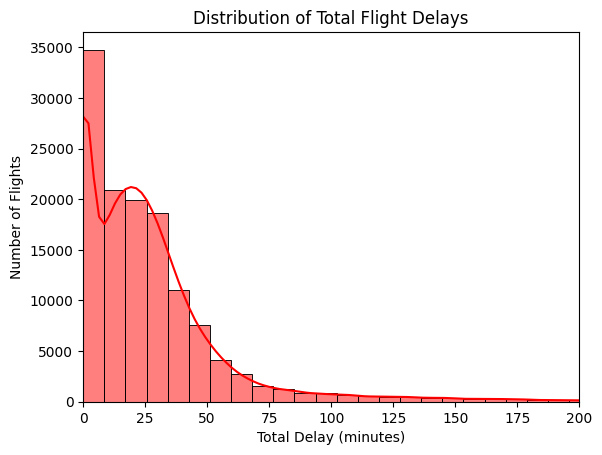

In [28]:
# Total Delay distribution
sns.histplot(flights["Total_Delay_min"], bins=50, kde=True, color="red")
plt.title("Distribution of Total Flight Delays")
plt.xlabel("Total Delay (minutes)")
plt.ylabel("Number of Flights")
plt.xlim(0, 200)  # Focus on reasonable delay range
plt.show()


In [29]:
flights["On_Time"].value_counts()
flights["Delay_Category"].value_counts()


Delay_Category
Minor         66825
On Time       50671
Major         10512
Cancelled      2491
Very Major     1307
Name: count, dtype: int64

C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\3260173676.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=on_time_counts.index, y=on_time_counts.values, palette="Set2")


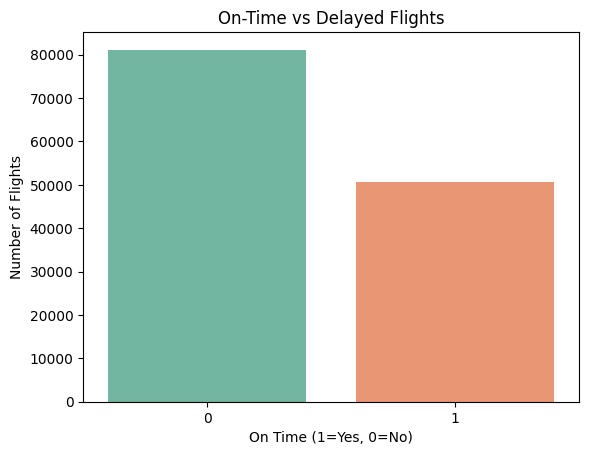

In [30]:
on_time_counts = flights["On_Time"].value_counts()

sns.barplot(x=on_time_counts.index, y=on_time_counts.values, palette="Set2")
plt.title("On-Time vs Delayed Flights")
plt.xlabel("On Time (1=Yes, 0=No)")
plt.ylabel("Number of Flights")
plt.show()


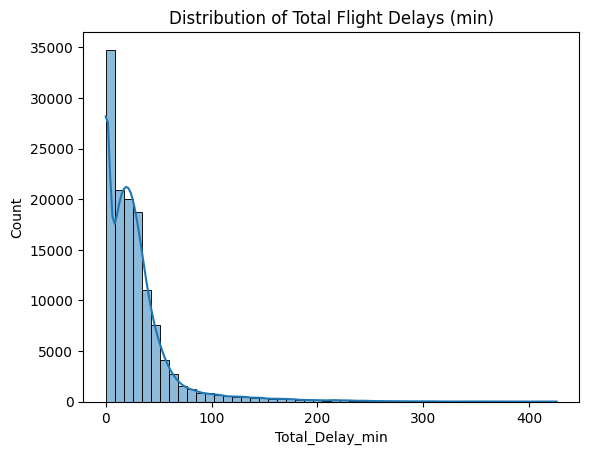

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(flights["Total_Delay_min"], bins=50, kde=True)
plt.title("Distribution of Total Flight Delays (min)")
plt.show()


In [32]:
flights.groupby("Airline_Name")["Ticket_Price_INR"].mean().sort_values(ascending=False)


Airline_Name
SpiceJet              21273.112490
Lufthansa             20858.508029
IndiGo                20783.440962
Emirates              20733.002404
Singapore Airlines    20715.663822
Akasa Air             20691.621349
Air India             20449.982842
Vistara               20366.944226
AirAsia India         20255.080033
Qatar Airways         20200.993806
Name: Ticket_Price_INR, dtype: float64

C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\1779011386.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_airline.index, y=avg_price_airline.values, palette='viridis')


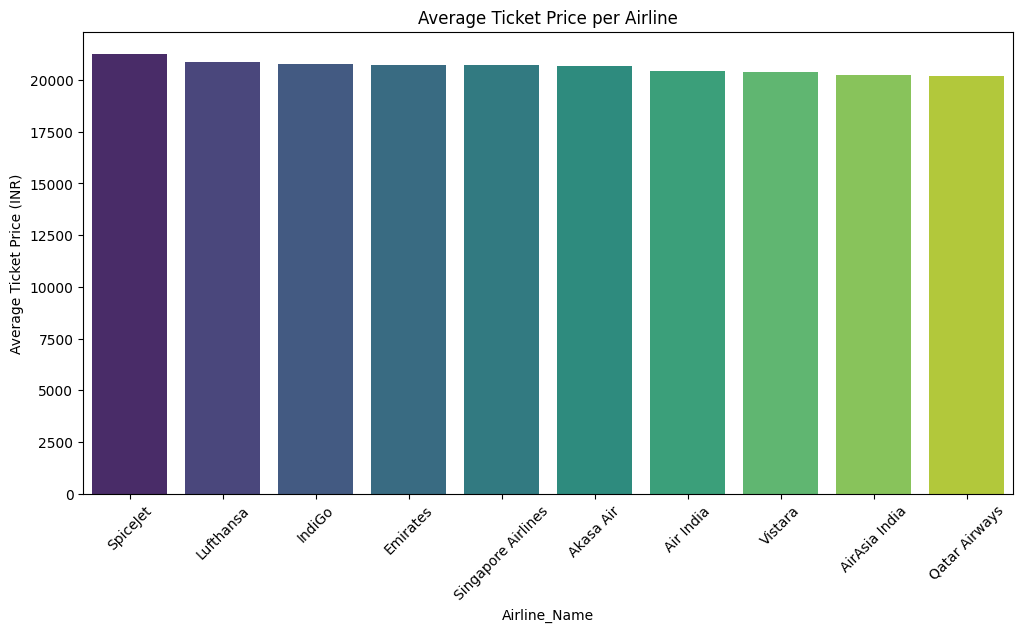

In [33]:
avg_price_airline = flights.groupby('Airline_Name')['Ticket_Price_INR'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_price_airline.index, y=avg_price_airline.values, palette='viridis')
plt.xticks(rotation=45)
plt.ylabel('Average Ticket Price (INR)')
plt.title('Average Ticket Price per Airline')
plt.show()


In [34]:
flights["Fare_Type"].value_counts()


Fare_Type
Economy           113796
Business            8987
PremiumEconomy      6532
Name: count, dtype: int64

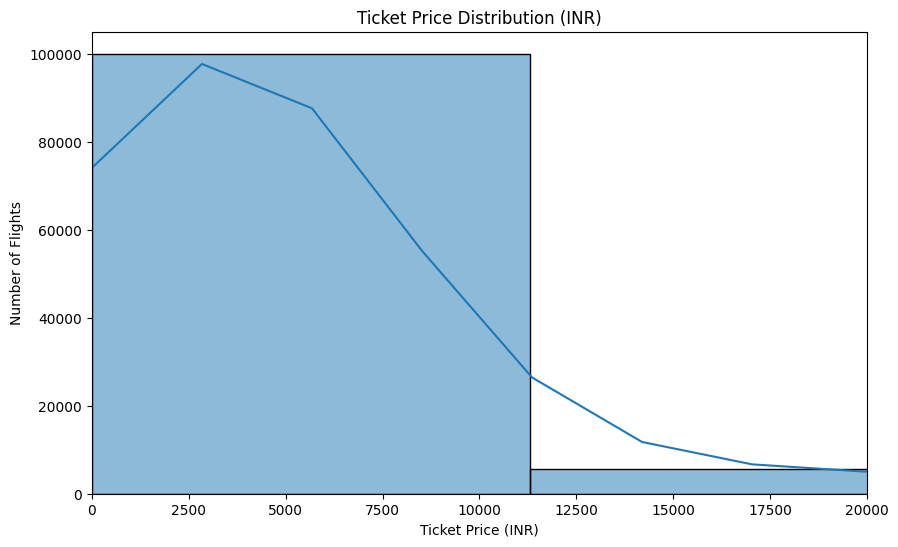

In [35]:
plt.figure(figsize=(10,6))
sns.histplot(flights['Ticket_Price_INR'], bins=50, kde=True, color='#1f77b4')
plt.title('Ticket Price Distribution (INR)')
plt.xlabel('Ticket Price (INR)')
plt.ylabel('Number of Flights')
plt.xlim(0, 20000)  # optional: focus on main price range
plt.show()


In [36]:
flights["Source_Airport"].value_counts().head(10)


Source_Airport
PYG    1374
SDW    1349
NMI    1346
AYJ    1340
RQY    1339
UKE    1319
HGI    1317
REW    1297
JGB    1293
RJI    1289
Name: count, dtype: int64

C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\3327111474.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_airports.index, y=top_airports.values, palette='coolwarm')


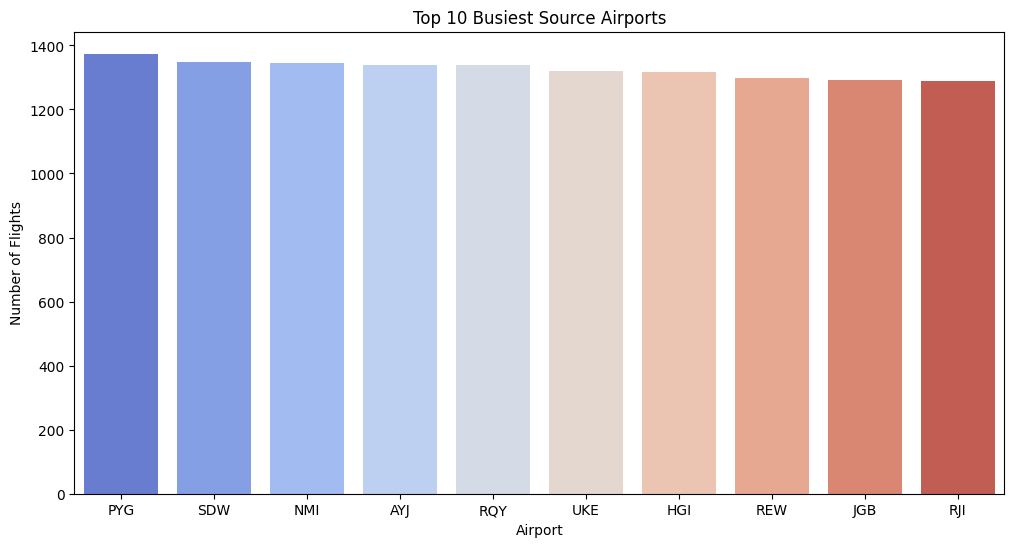

In [37]:
top_airports = flights['Source_Airport'].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_airports.index, y=top_airports.values, palette='coolwarm')
plt.title('Top 10 Busiest Source Airports')
plt.ylabel('Number of Flights')
plt.xlabel('Airport')
plt.show()


In [38]:
flights["Destination_Airport"].value_counts().head(10)


Destination_Airport
WGC    1374
TRZ    1367
TRV    1353
TIR    1340
TJV    1338
TCR    1338
RJA    1323
SXV    1320
RMD    1313
PNY    1303
Name: count, dtype: int64

C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\572257137.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_airports.index, y=top_airports.values, palette='coolwarm')


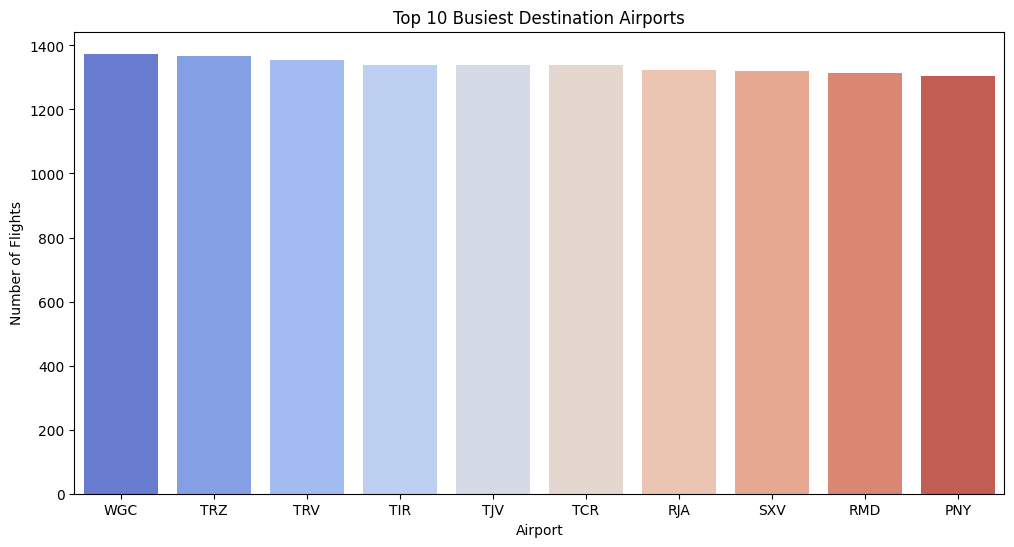

In [39]:
top_airports = flights['Destination_Airport'].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_airports.index, y=top_airports.values, palette='coolwarm')
plt.title('Top 10 Busiest Destination Airports')
plt.ylabel('Number of Flights')
plt.xlabel('Airport')
plt.show()


In [40]:
flights.groupby(["Source_Airport","Destination_Airport"]).size().sort_values(ascending=False).head(10)


Source_Airport  Destination_Airport
VTZ             KQH                    10
                TNI                    10
ZER             VSV                    10
                VGA                    10
VTZ             BKB                    10
                DEL                    10
ZER             HDO                    10
                TCR                    10
                VDY                    10
                PGH                    10
dtype: int64

C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\3710873227.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_routes.index.map(lambda x: f"{x[0]} → {x[1]}"), y=top_routes.values, palette='magma')


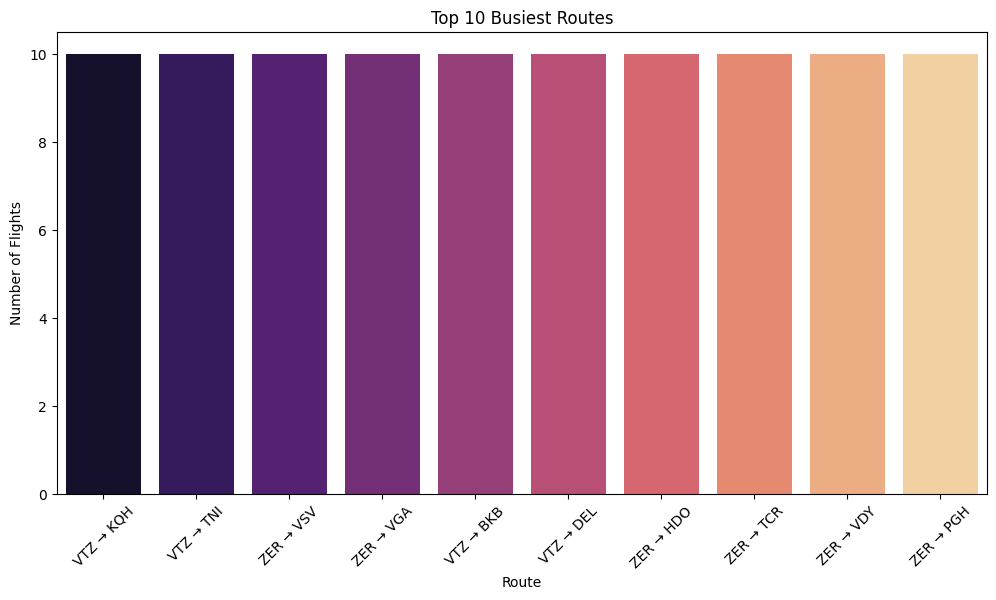

In [41]:
top_routes = flights.groupby(['Source_Airport','Destination_Airport']).size().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_routes.index.map(lambda x: f"{x[0]} → {x[1]}"), y=top_routes.values, palette='magma')
plt.xticks(rotation=45)
plt.title('Top 10 Busiest Routes')
plt.ylabel('Number of Flights')
plt.xlabel('Route')
plt.show()


In [42]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

# Load enriched flight-level dataset
flights = pd.read_csv("data/flight_level_enriched.csv")
flights.head(3)


,Flight_ID,Flight_Number,Airline_Name,Airline_Code,Date,Year,Month,Day_of_Week,Source_Airport,Destination_Airport,...,Total_Delay_min,Cancelled,Cancellation_Reason,Fare_Type,Base_Fare_INR,Tax_INR,Ticket_Price_INR,On_Time,Delay_Category,Flight_Performance_Score
0,F000001,AI381,Air India,AI,2024-01-24,2024,1,Wednesday,PYG,AYJ,...,29.0,0,NaN,Economy,1348,153,1501,0,Minor,8.91
1,F000002,UK792,Vistara,UK,2024-12-04,2024,12,Wednesday,PYG,AYJ,...,24.0,0,NaN,Economy,1949,171,2120,0,Minor,9.26
2,F000003,LH130,Lufthansa,LH,2024-07-02,2024,7,Tuesday,PYG,AYJ,...,29.0,0,NaN,Economy,1341,239,1580,0,Minor,9.09


In [43]:
# Shape and columns
print("Shape:", flights.shape)
print("\nColumns:", flights.columns.tolist())

# Null value check
print("\nNull values per column:")
print(flights.isnull().sum())


Shape: (131806, 31)

Columns: ['Flight_ID', 'Flight_Number', 'Airline_Name', 'Airline_Code', 'Date', 'Year', 'Month', 'Day_of_Week', 'Source_Airport', 'Destination_Airport', 'Route_Type', 'Distance_km', 'Flight_Duration_min', 'Departure_Time', 'Arrival_Time', 'Country_Source', 'Country_Dest', 'Region_Pair', 'Departure_Time_Bin', 'Departure_Delay_min', 'Arrival_Delay_min', 'Total_Delay_min', 'Cancelled', 'Cancellation_Reason', 'Fare_Type', 'Base_Fare_INR', 'Tax_INR', 'Ticket_Price_INR', 'On_Time', 'Delay_Category', 'Flight_Performance_Score']

Null values per column:
Flight_ID                        0
Flight_Number                    0
Airline_Name                     0
Airline_Code                     0
Date                             0
Year                             0
Month                            0
Day_of_Week                      0
Source_Airport                   0
Destination_Airport              0
Route_Type                       0
Distance_km                      0
Flight_

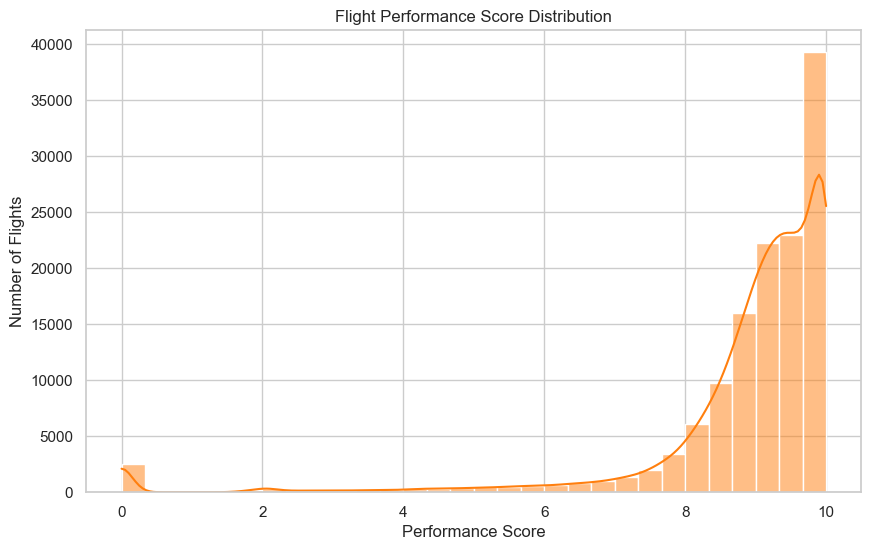

In [44]:
plt.figure(figsize=(10,6))
sns.histplot(flights['Flight_Performance_Score'], bins=30, kde=True, color='#ff7f0e')
plt.title('Flight Performance Score Distribution')
plt.xlabel('Performance Score')
plt.ylabel('Number of Flights')
plt.show()


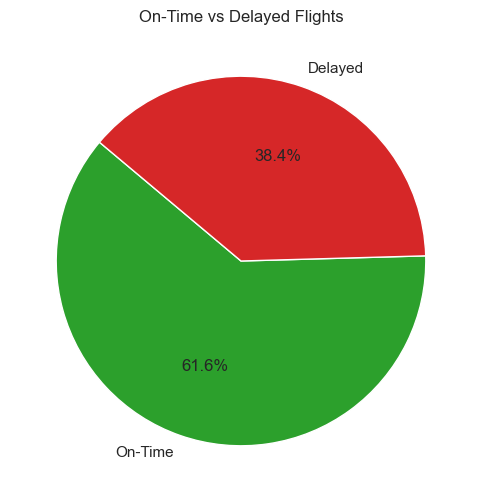

In [45]:
on_time_counts = flights['On_Time'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(on_time_counts, labels=['On-Time','Delayed'], autopct='%1.1f%%', startangle=140, colors=['#2ca02c','#d62728'])
plt.title('On-Time vs Delayed Flights')
plt.show()


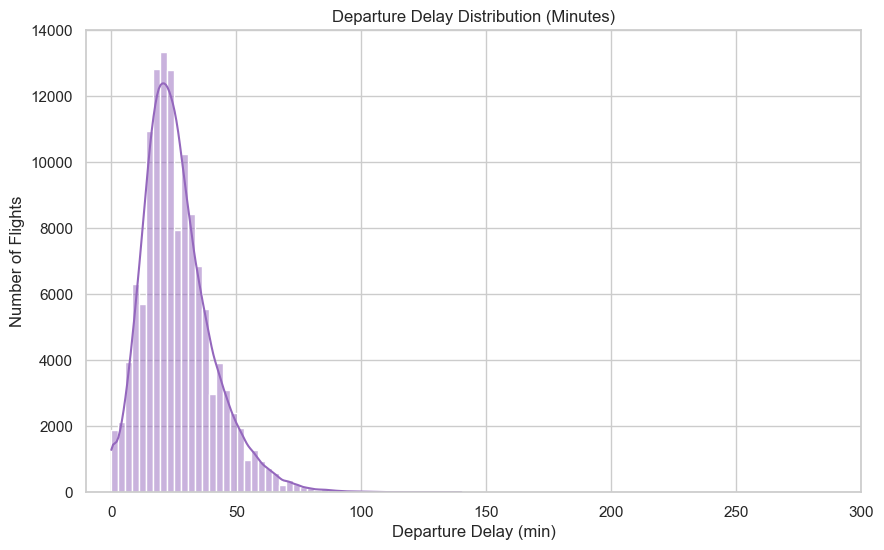

In [46]:
plt.figure(figsize=(10,6))
sns.histplot(flights['Departure_Delay_min'], bins=50, kde=True, color='#9467bd')
plt.title('Departure Delay Distribution (Minutes)')
plt.xlabel('Departure Delay (min)')
plt.ylabel('Number of Flights')
plt.xlim(-10, 300)  # optional: ignore extreme outliers
plt.show()


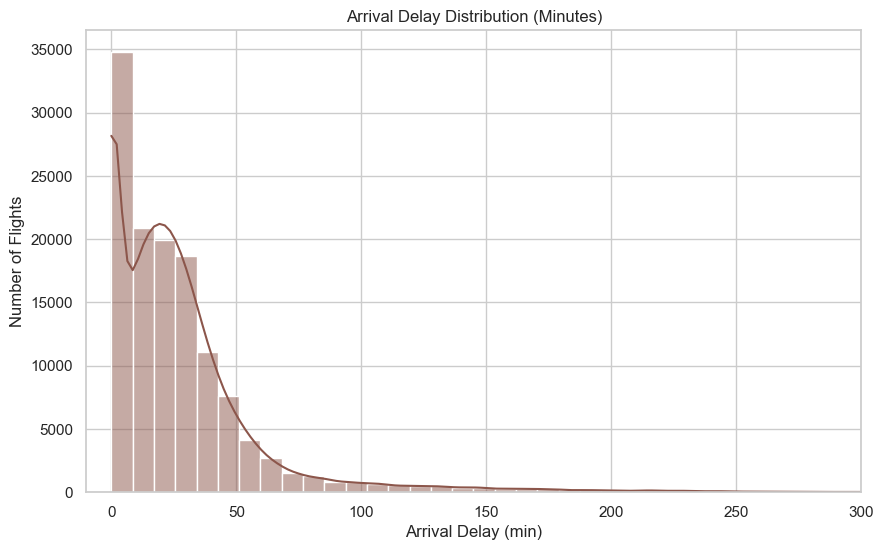

In [47]:
plt.figure(figsize=(10,6))
sns.histplot(flights['Arrival_Delay_min'], bins=50, kde=True, color='#8c564b')
plt.title('Arrival Delay Distribution (Minutes)')
plt.xlabel('Arrival Delay (min)')
plt.ylabel('Number of Flights')
plt.xlim(-10, 300)  # optional
plt.show()


C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\822544118.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_total_delay_airline.index, y=avg_total_delay_airline.values, palette='Set2')


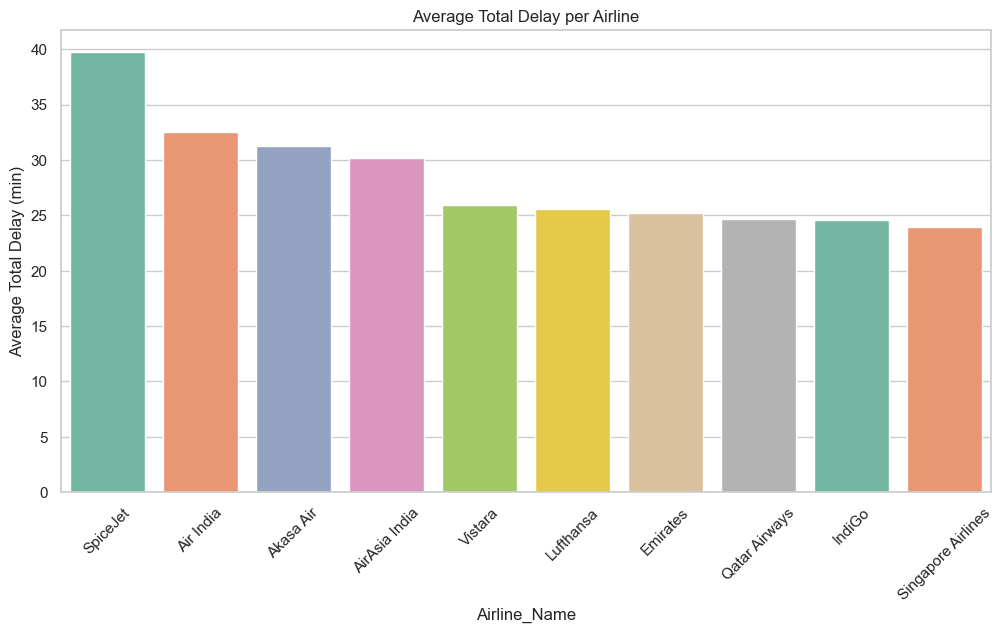

In [48]:
avg_total_delay_airline = flights.groupby('Airline_Name')['Total_Delay_min'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_total_delay_airline.index, y=avg_total_delay_airline.values, palette='Set2')
plt.xticks(rotation=45)
plt.ylabel('Average Total Delay (min)')
plt.title('Average Total Delay per Airline')
plt.show()


C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\4155847853.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Route_Type', y='Total_Delay_min', data=flights, palette=['#1f77b4','#ff7f0e'])


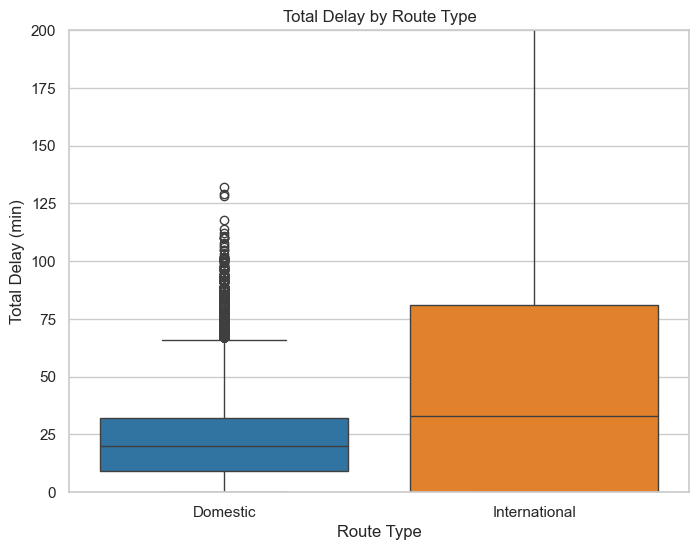

In [49]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Route_Type', y='Total_Delay_min', data=flights, palette=['#1f77b4','#ff7f0e'])
plt.title('Total Delay by Route Type')
plt.ylabel('Total Delay (min)')
plt.xlabel('Route Type')
plt.ylim(0, 200)  # focus on main delay range
plt.show()


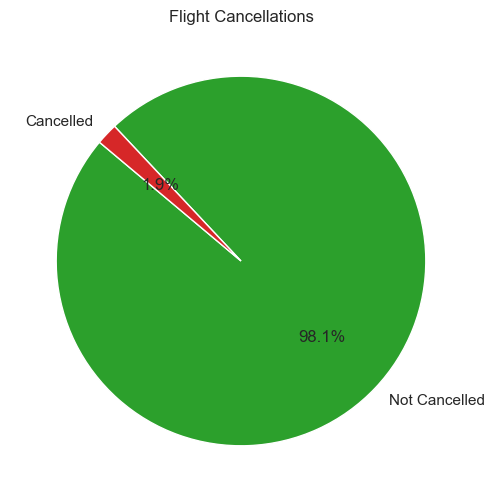

In [50]:
cancel_counts = flights['Cancelled'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(cancel_counts, labels=['Not Cancelled','Cancelled'], autopct='%1.1f%%', startangle=140, colors=['#2ca02c','#d62728'])
plt.title('Flight Cancellations')
plt.show()


C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\1764932647.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_dep_delay.index, y=avg_dep_delay.values, palette="viridis")


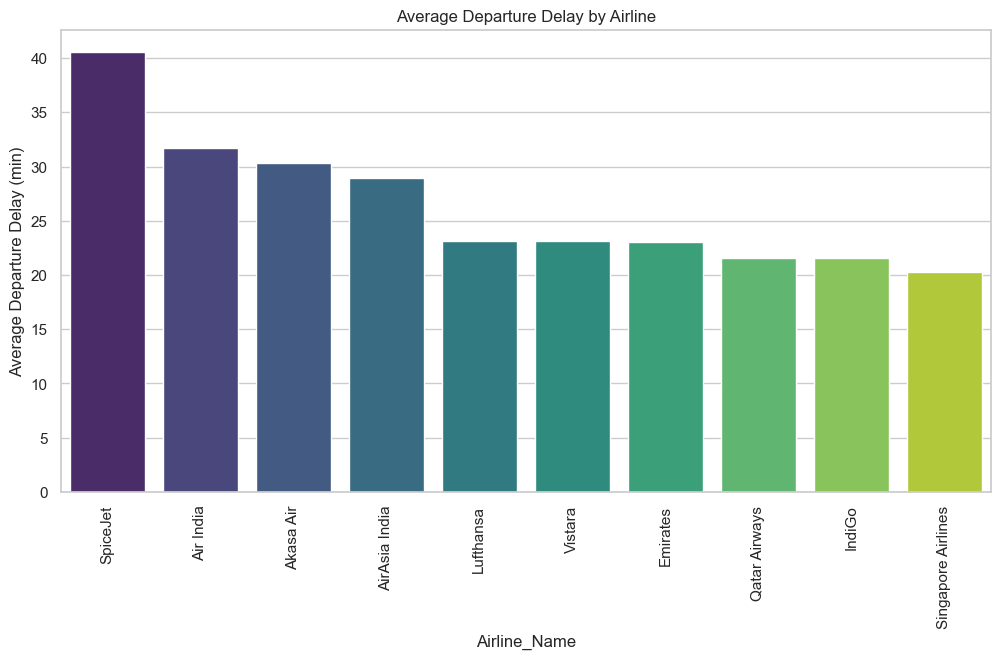

In [51]:
# Average departure delay per airline
avg_dep_delay = flights.groupby("Airline_Name")["Departure_Delay_min"].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_dep_delay.index, y=avg_dep_delay.values, palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("Average Departure Delay (min)")
plt.title("Average Departure Delay by Airline")
plt.show()


C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\2869047223.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_arr_delay.index, y=avg_arr_delay.values, palette="magma")


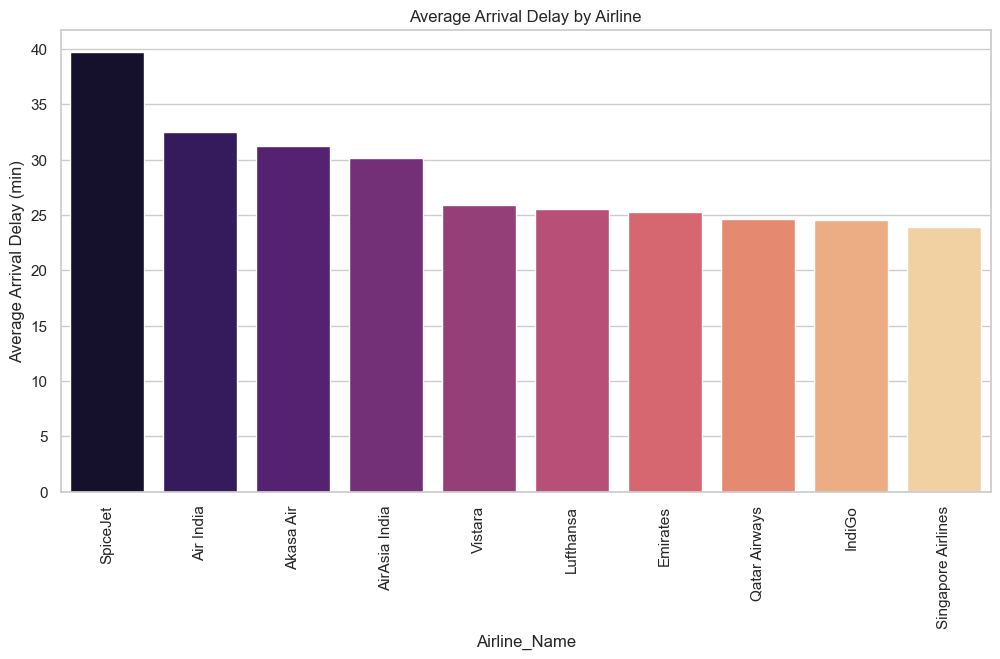

In [52]:
# Average arrival delay per airline
avg_arr_delay = flights.groupby("Airline_Name")["Arrival_Delay_min"].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_arr_delay.index, y=avg_arr_delay.values, palette="magma")
plt.xticks(rotation=90)
plt.ylabel("Average Arrival Delay (min)")
plt.title("Average Arrival Delay by Airline")
plt.show()


C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\3486265705.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_total_delay.index, y=avg_total_delay.values, palette=["#4CAF50", "#FFC107"])


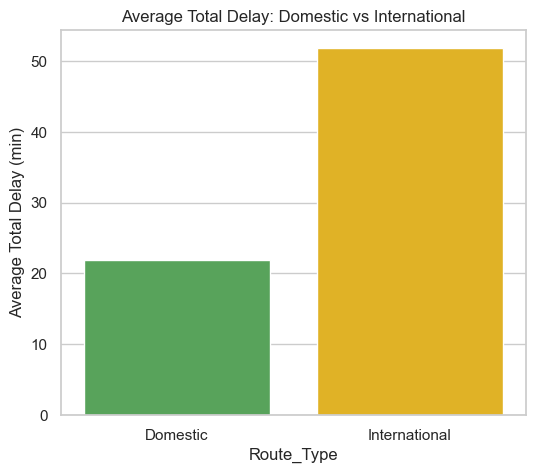

In [53]:
# Domestic vs International total delay
avg_total_delay = flights.groupby("Route_Type")["Total_Delay_min"].mean()

plt.figure(figsize=(6,5))
sns.barplot(x=avg_total_delay.index, y=avg_total_delay.values, palette=["#4CAF50", "#FFC107"])
plt.ylabel("Average Total Delay (min)")
plt.title("Average Total Delay: Domestic vs International")
plt.show()


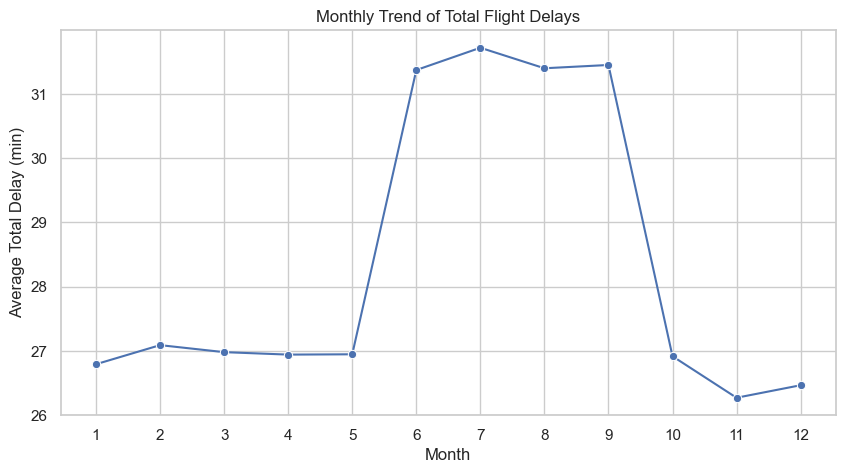

In [54]:
# Monthly trend of total delay
monthly_delay = flights.groupby("Month")["Total_Delay_min"].mean()

plt.figure(figsize=(10,5))
sns.lineplot(x=monthly_delay.index, y=monthly_delay.values, marker="o")
plt.xticks(range(1,13))
plt.ylabel("Average Total Delay (min)")
plt.title("Monthly Trend of Total Flight Delays")
plt.show()


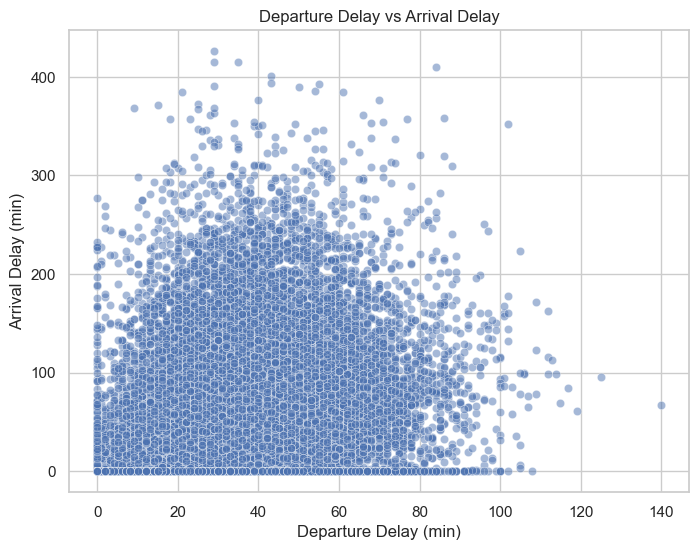

In [55]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="Departure_Delay_min", y="Arrival_Delay_min", data=flights, alpha=0.5)
plt.xlabel("Departure Delay (min)")
plt.ylabel("Arrival Delay (min)")
plt.title("Departure Delay vs Arrival Delay")
plt.show()


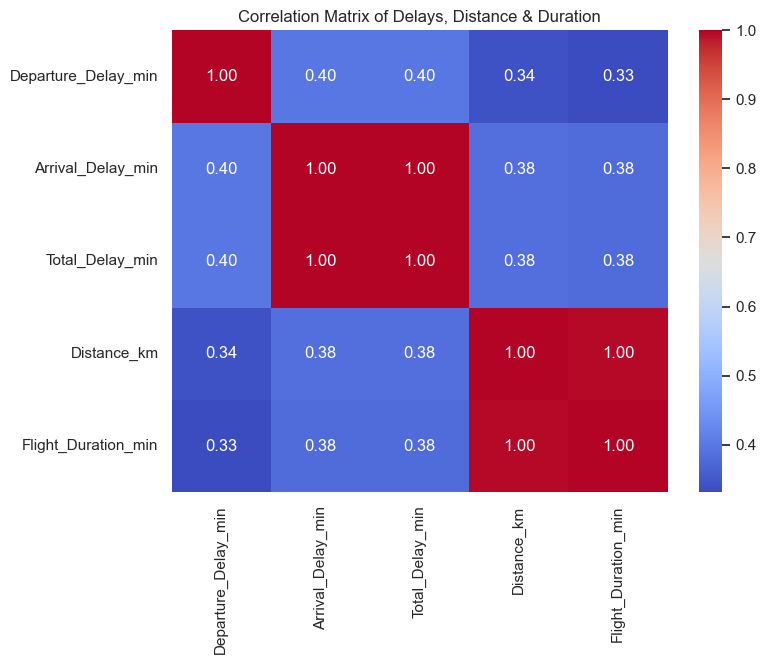

In [56]:
# Correlation between delay, distance, duration
corr_cols = ["Departure_Delay_min", "Arrival_Delay_min", "Total_Delay_min", "Distance_km", "Flight_Duration_min"]
plt.figure(figsize=(8,6))
sns.heatmap(flights[corr_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Delays, Distance & Duration")
plt.show()


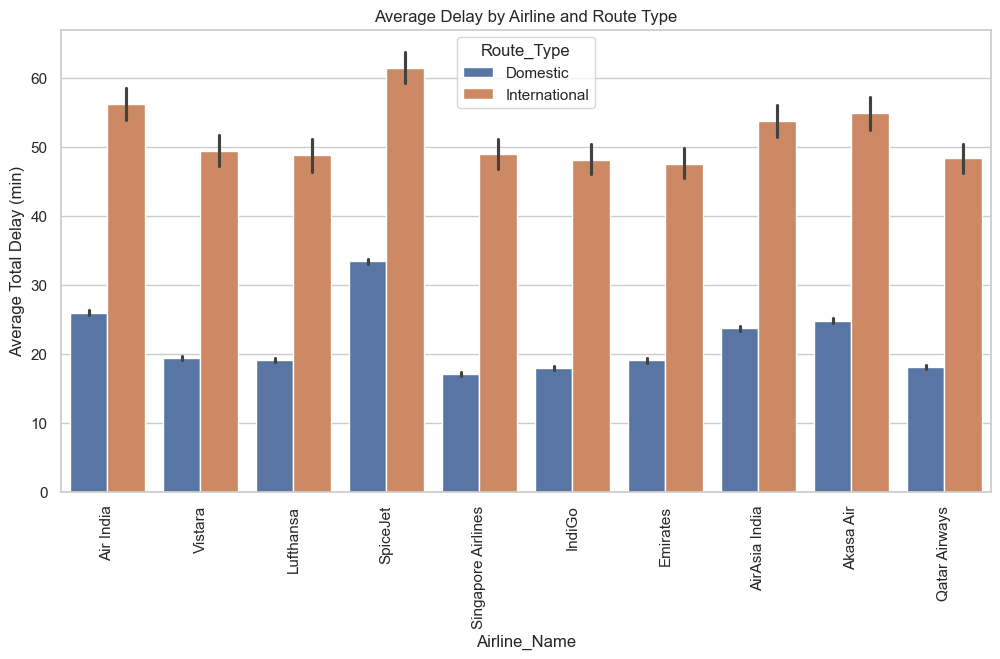

In [57]:
# Average total delay per airline and route type
plt.figure(figsize=(12,6))
sns.barplot(x="Airline_Name", y="Total_Delay_min", hue="Route_Type", data=flights, estimator=np.mean)
plt.xticks(rotation=90)
plt.ylabel("Average Total Delay (min)")
plt.title("Average Delay by Airline and Route Type")
plt.show()


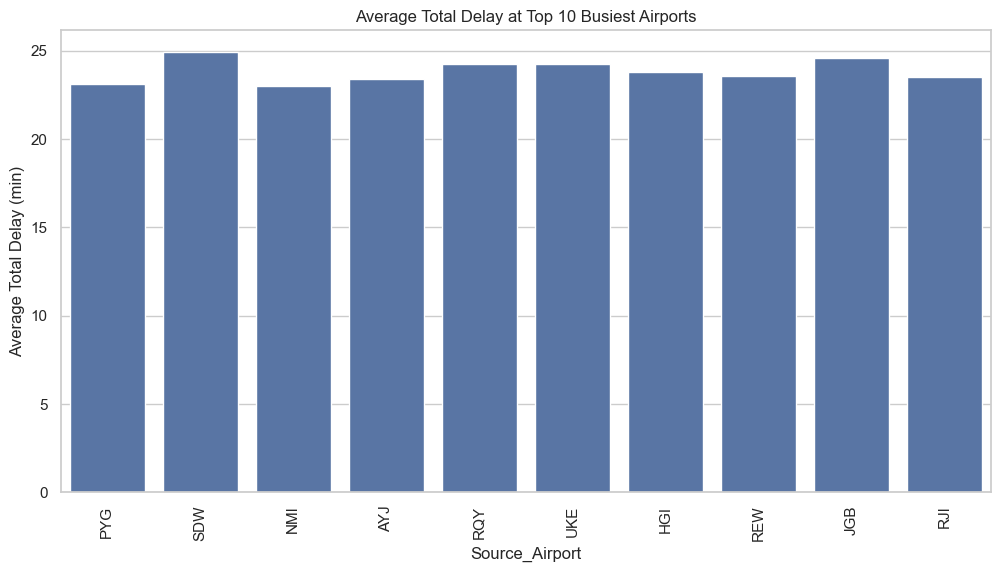

In [58]:
# Top 10 busiest airports
top_airports = flights["Source_Airport"].value_counts().head(10).index
plt.figure(figsize=(12,6))
sns.barplot(x=top_airports, y=flights[flights["Source_Airport"].isin(top_airports)].groupby("Source_Airport")["Total_Delay_min"].mean())
plt.xticks(rotation=90)
plt.ylabel("Average Total Delay (min)")
plt.title("Average Total Delay at Top 10 Busiest Airports")
plt.show()


C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\1375255535.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_fare_airline.index, y=avg_fare_airline.values, palette="coolwarm")


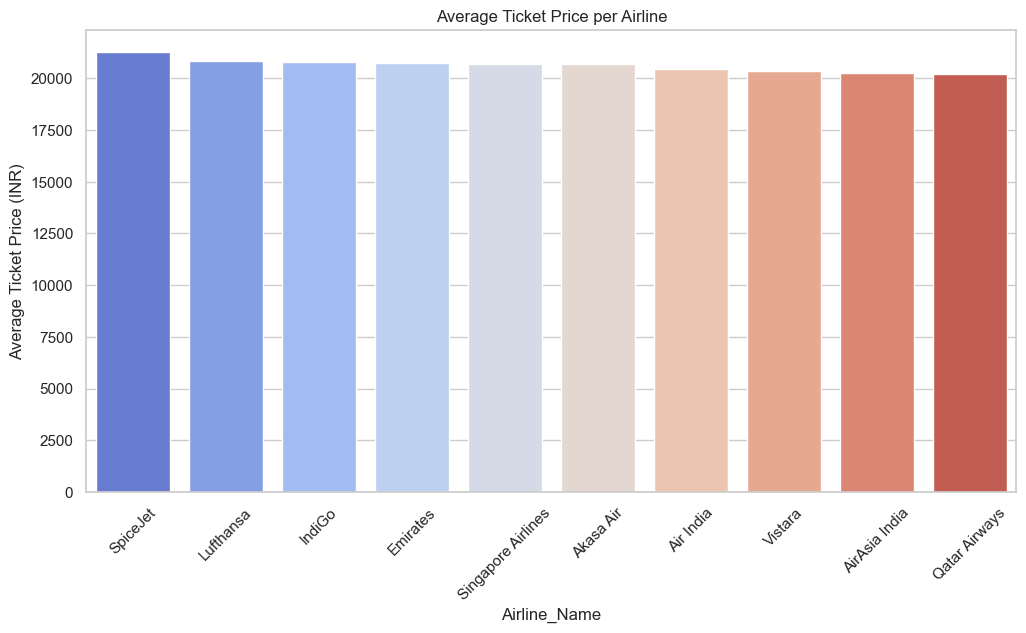

In [59]:
# Average Ticket Price per Airline
avg_fare_airline = flights.groupby("Airline_Name")["Ticket_Price_INR"].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_fare_airline.index, y=avg_fare_airline.values, palette="coolwarm")
plt.xticks(rotation=45)
plt.ylabel("Average Ticket Price (INR)")
plt.title("Average Ticket Price per Airline")
plt.show()


C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\1077286643.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Route_Type", y="Ticket_Price_INR", data=flights, palette=["#4CAF50", "#FFC107"])


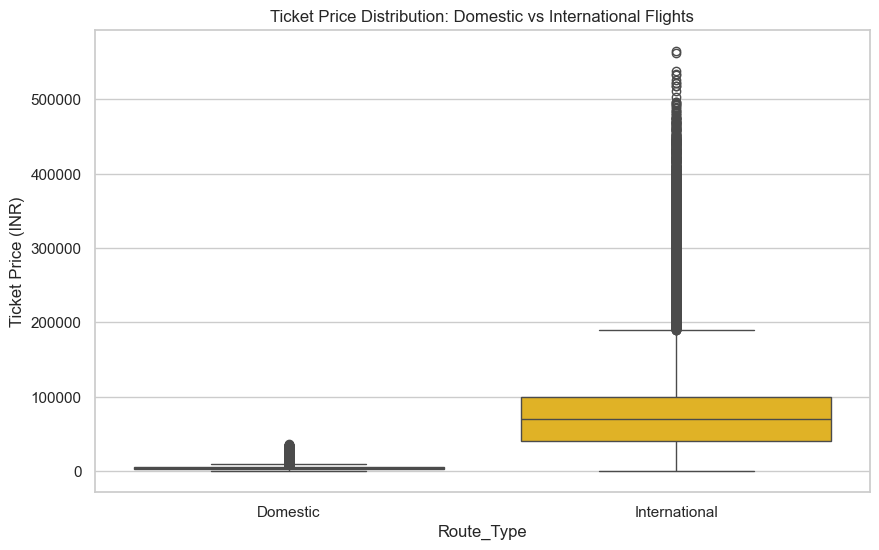

In [60]:
plt.figure(figsize=(10,6))
sns.boxplot(x="Route_Type", y="Ticket_Price_INR", data=flights, palette=["#4CAF50", "#FFC107"])
plt.title("Ticket Price Distribution: Domestic vs International Flights")
plt.ylabel("Ticket Price (INR)")
plt.show()


C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\2622321926.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=perf_score_airline.index, y=perf_score_airline.values, palette="viridis")


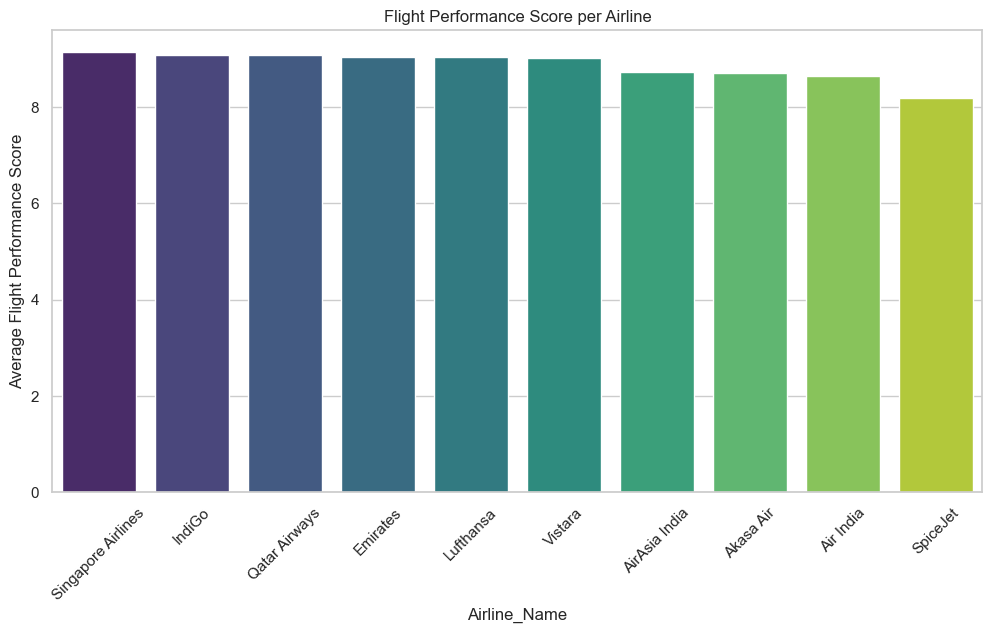

In [61]:
# Flight Performance Score by Airline
perf_score_airline = flights.groupby("Airline_Name")["Flight_Performance_Score"].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=perf_score_airline.index, y=perf_score_airline.values, palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("Average Flight Performance Score")
plt.title("Flight Performance Score per Airline")
plt.show()


C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\3885730430.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=on_time_airline.index, y=on_time_airline.values, palette="magma")


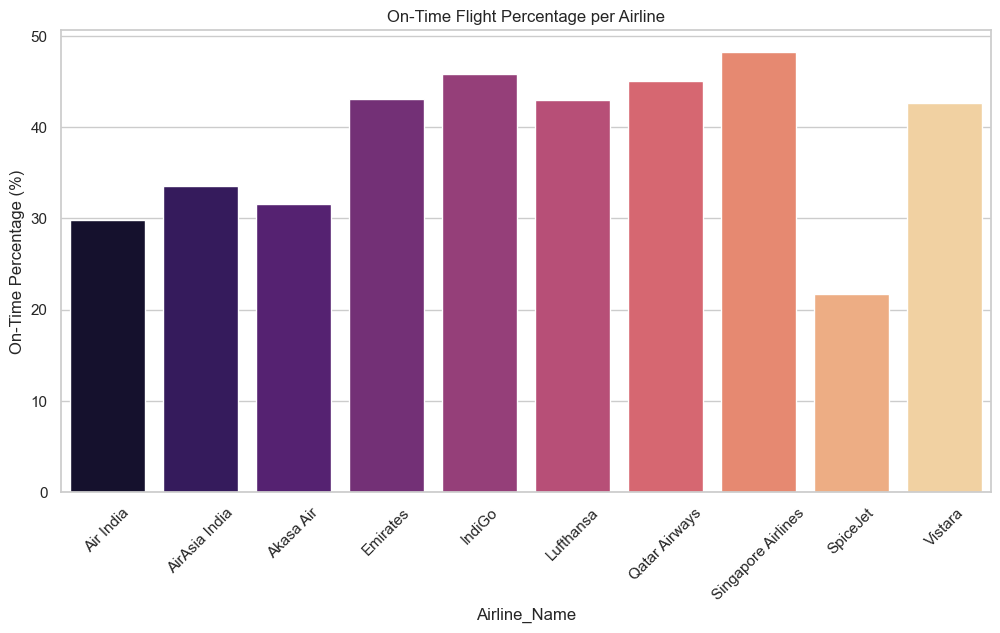

In [62]:
# On-Time Flight Percentage
on_time_airline = flights.groupby("Airline_Name")["On_Time"].mean() * 100

plt.figure(figsize=(12,6))
sns.barplot(x=on_time_airline.index, y=on_time_airline.values, palette="magma")
plt.xticks(rotation=45)
plt.ylabel("On-Time Percentage (%)")
plt.title("On-Time Flight Percentage per Airline")
plt.show()


C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\2400186662.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_airports.index, y=top_airports.values, palette="cubehelix")


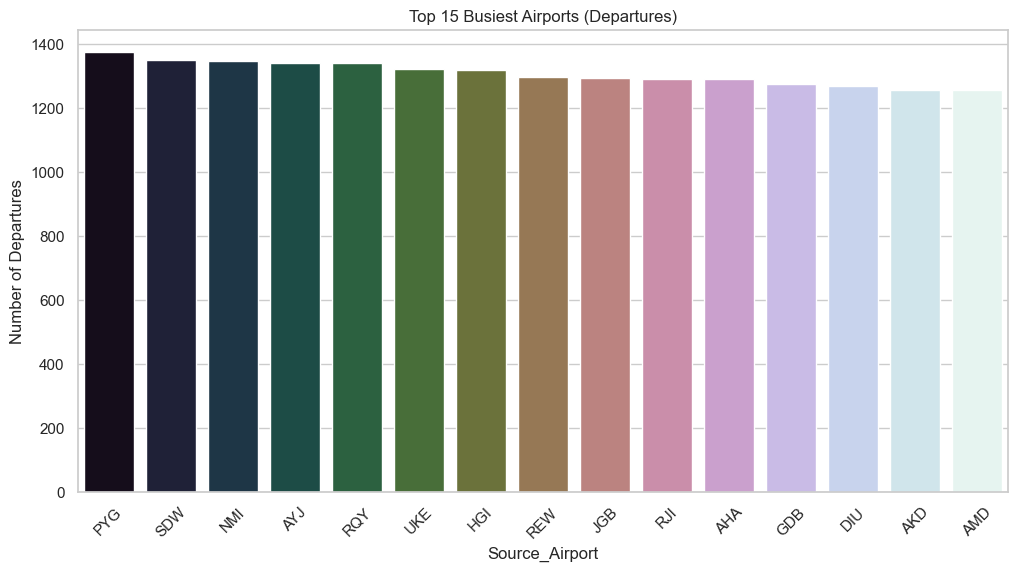

In [63]:
top_airports = flights["Source_Airport"].value_counts().head(15)

plt.figure(figsize=(12,6))
sns.barplot(x=top_airports.index, y=top_airports.values, palette="cubehelix")
plt.xticks(rotation=45)
plt.ylabel("Number of Departures")
plt.title("Top 15 Busiest Airports (Departures)")
plt.show()


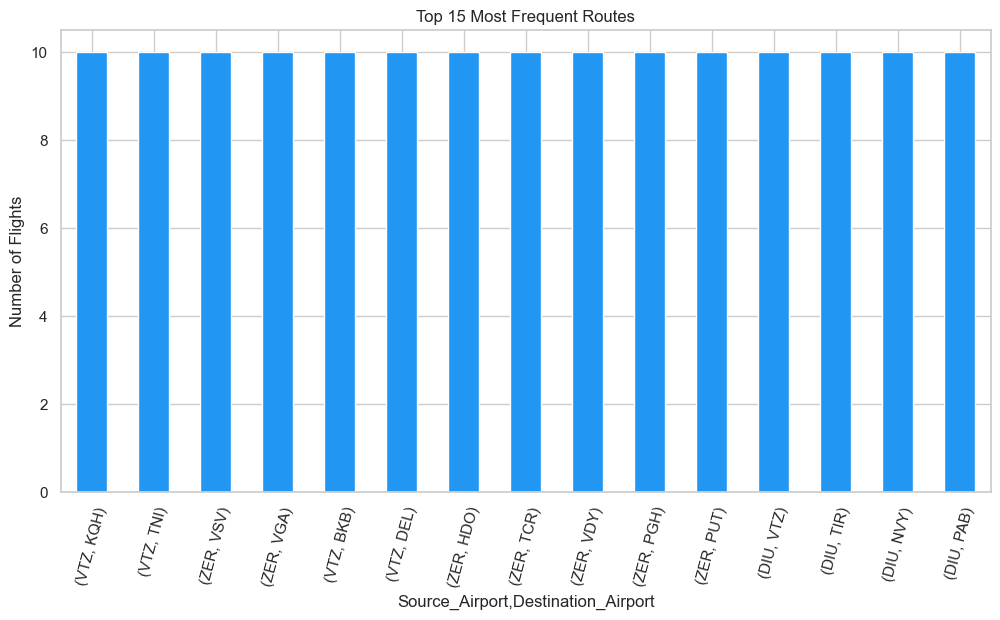

In [64]:
top_routes = flights.groupby(["Source_Airport", "Destination_Airport"]).size().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,6))
top_routes.plot(kind="bar", color="#2196F3")
plt.ylabel("Number of Flights")
plt.title("Top 15 Most Frequent Routes")
plt.xticks(rotation=75)
plt.show()


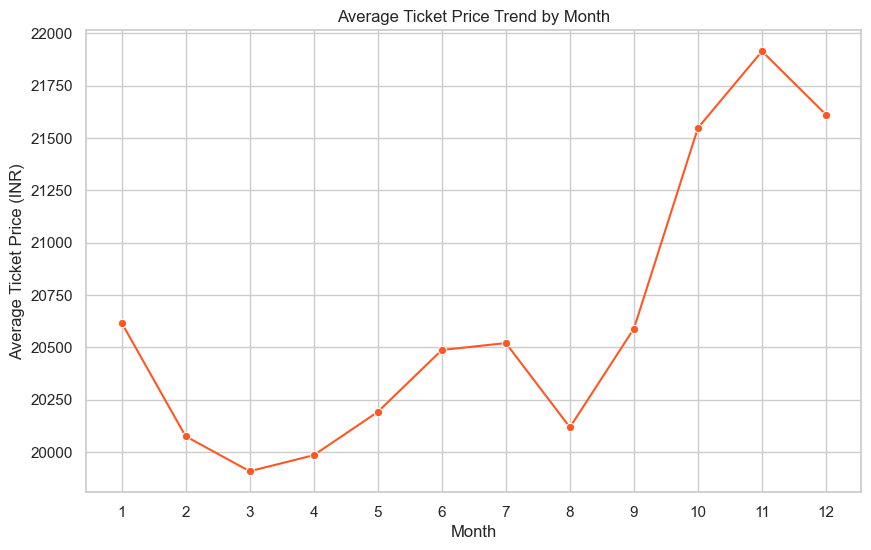

In [65]:
avg_fare_month = flights.groupby("Month")["Ticket_Price_INR"].mean()

plt.figure(figsize=(10,6))
sns.lineplot(x=avg_fare_month.index, y=avg_fare_month.values, marker="o", color="#FF5722")
plt.xticks(range(1,13))
plt.ylabel("Average Ticket Price (INR)")
plt.title("Average Ticket Price Trend by Month")
plt.show()


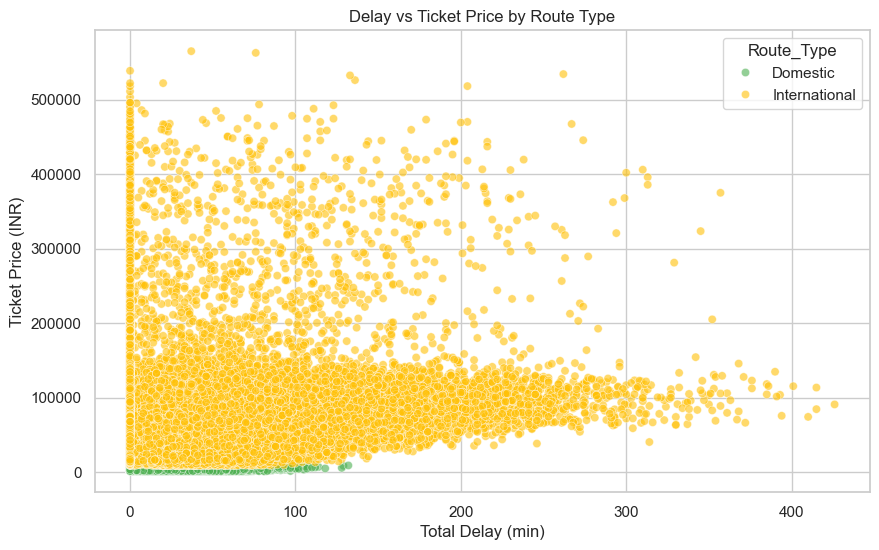

In [66]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="Total_Delay_min", y="Ticket_Price_INR", hue="Route_Type", data=flights, alpha=0.6, palette=["#4CAF50","#FFC107"])
plt.xlabel("Total Delay (min)")
plt.ylabel("Ticket Price (INR)")
plt.title("Delay vs Ticket Price by Route Type")
plt.show()


C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\3300437902.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Airline_Name", y="Total_Delay_min", data=flights, palette="Set2")


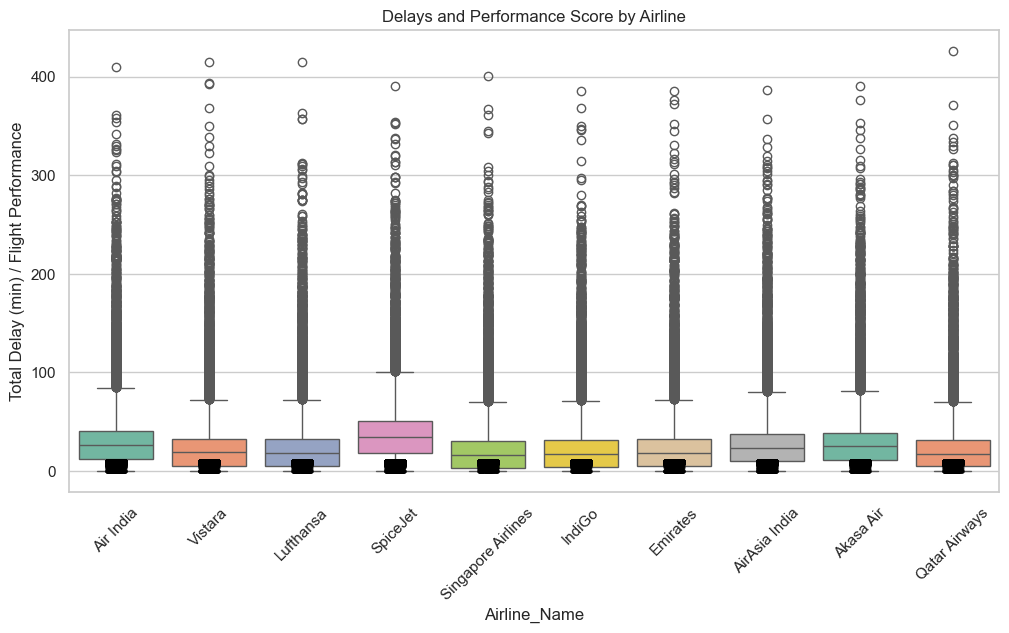

In [67]:
plt.figure(figsize=(12,6))
sns.boxplot(x="Airline_Name", y="Total_Delay_min", data=flights, palette="Set2")
sns.stripplot(x="Airline_Name", y="Flight_Performance_Score", data=flights, color="black", size=3, jitter=True, alpha=0.3)
plt.xticks(rotation=45)
plt.ylabel("Total Delay (min) / Flight Performance")
plt.title("Delays and Performance Score by Airline")
plt.show()


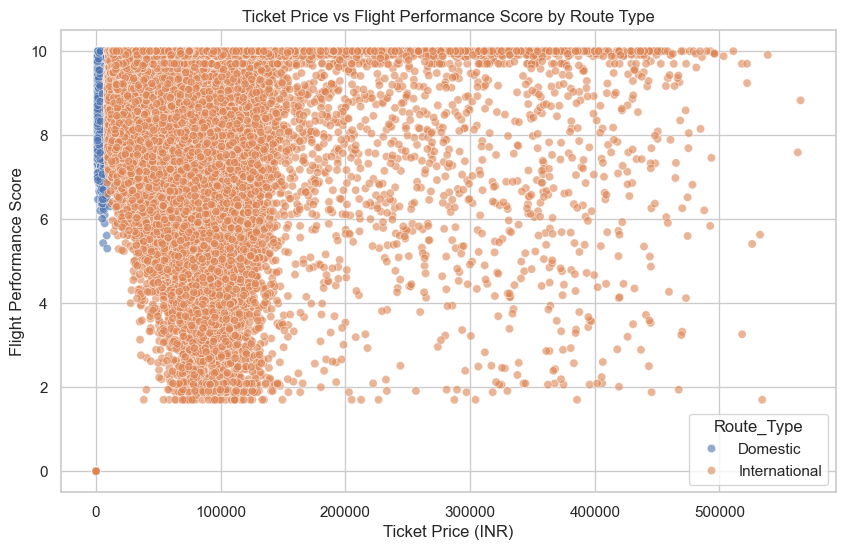

In [68]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="Ticket_Price_INR", y="Flight_Performance_Score", hue="Route_Type", data=flights, alpha=0.6)
plt.xlabel("Ticket Price (INR)")
plt.ylabel("Flight Performance Score")
plt.title("Ticket Price vs Flight Performance Score by Route Type")
plt.show()


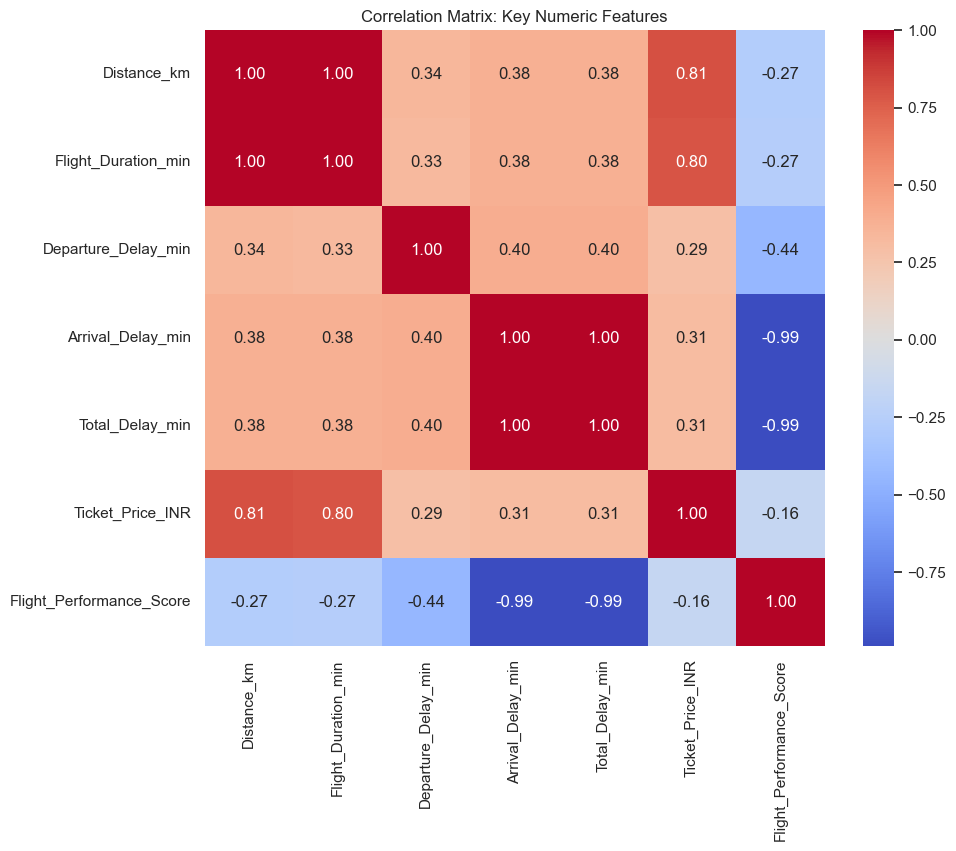

In [69]:
numeric_cols = ["Distance_km", "Flight_Duration_min", "Departure_Delay_min", "Arrival_Delay_min", "Total_Delay_min", "Ticket_Price_INR", "Flight_Performance_Score"]
plt.figure(figsize=(10,8))
sns.heatmap(flights[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Key Numeric Features")
plt.show()


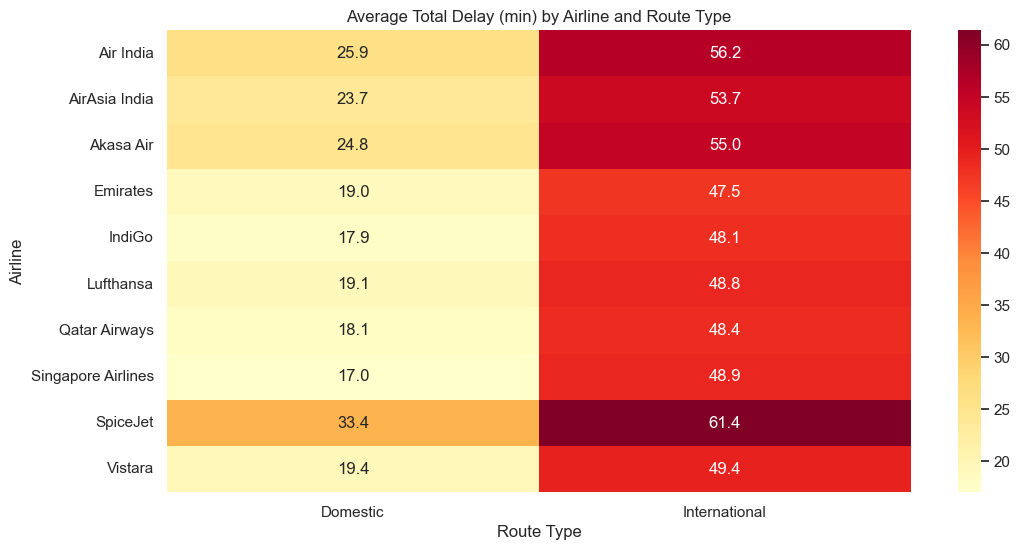

In [70]:
avg_delay = flights.groupby(["Airline_Name", "Route_Type"])["Total_Delay_min"].mean().unstack()

plt.figure(figsize=(12,6))
sns.heatmap(avg_delay, annot=True, fmt=".1f", cmap="YlOrRd")
plt.ylabel("Airline")
plt.xlabel("Route Type")
plt.title("Average Total Delay (min) by Airline and Route Type")
plt.show()


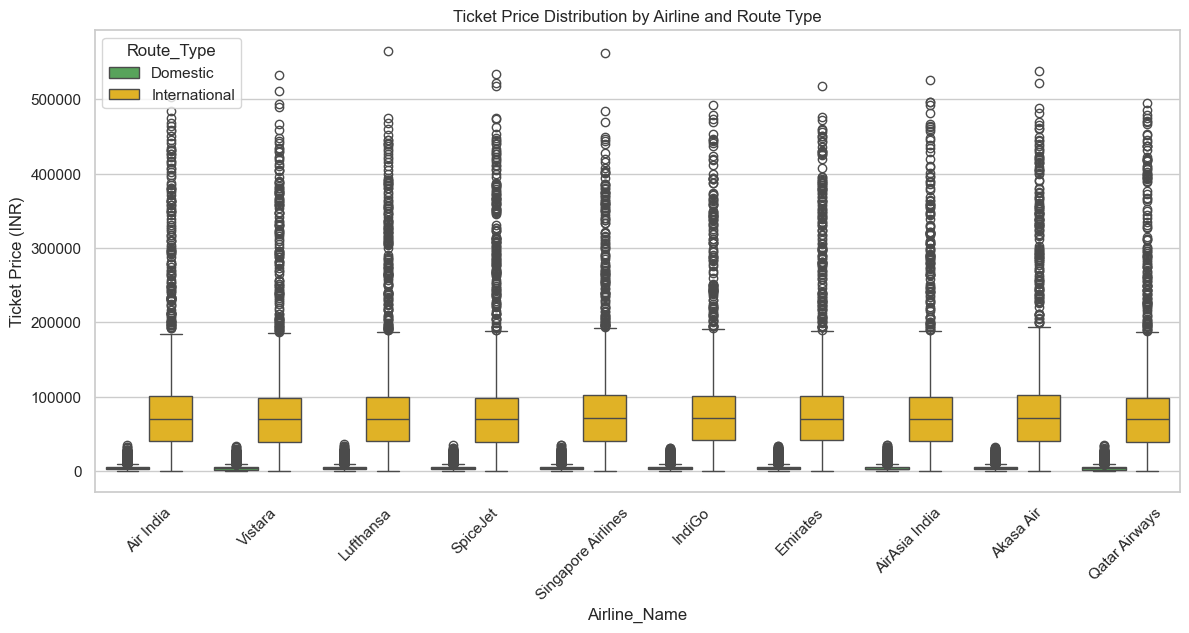

In [71]:
plt.figure(figsize=(14,6))
sns.boxplot(x="Airline_Name", y="Ticket_Price_INR", hue="Route_Type", data=flights, palette=["#4CAF50", "#FFC107"])
plt.xticks(rotation=45)
plt.ylabel("Ticket Price (INR)")
plt.title("Ticket Price Distribution by Airline and Route Type")
plt.show()


In [72]:
# Target: On-Time (1) vs Delayed (0)
# Consider flights with Total_Delay_min > 15 as Delayed
flights["Delayed_Flag"] = flights["Total_Delay_min"].apply(lambda x: 1 if x > 15 else 0)

flights["Delayed_Flag"].value_counts()


Delayed_Flag
1    78644
0    53162
Name: count, dtype: int64

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Copy relevant columns
model_data = flights[["Distance_km", "Flight_Duration_min", "Ticket_Price_INR",
                      "Airline_Name", "Route_Type", "Month", "Day_of_Week",
                      "Source_Airport", "Destination_Airport", "Delayed_Flag"]].copy()

# Encode categorical features
le_cols = ["Airline_Name", "Route_Type", "Day_of_Week", "Source_Airport", "Destination_Airport"]
for col in le_cols:
    le = LabelEncoder()
    model_data[col] = le.fit_transform(model_data[col])

# Split data
X = model_data.drop("Delayed_Flag", axis=1)
y = model_data["Delayed_Flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Model
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5970336089826265
[[  158 10475]
 [  148 15581]]
              precision    recall  f1-score   support

           0       0.52      0.01      0.03     10633
           1       0.60      0.99      0.75     15729

    accuracy                           0.60     26362
   macro avg       0.56      0.50      0.39     26362
weighted avg       0.57      0.60      0.46     26362



c:\Users\bhanu\OneDrive\Desktop\Indian_Airline_Analysis\airline_env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [75]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.5995372126545786
[[ 3609  7024]
 [ 3533 12196]]
              precision    recall  f1-score   support

           0       0.51      0.34      0.41     10633
           1       0.63      0.78      0.70     15729

    accuracy                           0.60     26362
   macro avg       0.57      0.56      0.55     26362
weighted avg       0.58      0.60      0.58     26362



In [76]:
import pandas as pd

# Load dataset
flights = pd.read_csv("data/flight_level_enriched.csv")

# Target variable: whether flight is delayed (1 if delayed, 0 if on time)
# We can consider Total_Delay_min > 0 as delayed
flights['Delayed'] = flights['Total_Delay_min'].apply(lambda x: 1 if x > 0 else 0)

# Features to use (numeric + categorical)
features = [
    'Distance_km', 
    'Flight_Duration_min', 
    'Month', 
    'Day_of_Week', 
    'Route_Type', 
    'Airline_Name'
]

X = flights[features]
y = flights['Delayed']

# Encode categorical features
X = pd.get_dummies(X, columns=['Day_of_Week', 'Route_Type', 'Airline_Name'], drop_first=True)

print("Feature shape:", X.shape)
print("Target distribution:\n", y.value_counts())


Feature shape: (131806, 19)
Target distribution:
 Delayed
1    107589
0     24217
Name: count, dtype: int64


In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (105444, 19)
Test set: (26362, 19)


In [78]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['Distance_km', 'Flight_Duration_min', 'Month']

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("Logistic Regression Accuracy:", logreg.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.665693043016463
[[ 2937  1907]
 [ 6906 14612]]
              precision    recall  f1-score   support

           0       0.30      0.61      0.40      4844
           1       0.88      0.68      0.77     21518

    accuracy                           0.67     26362
   macro avg       0.59      0.64      0.58     26362
weighted avg       0.78      0.67      0.70     26362



In [80]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=15, 
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", rf.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.72107579091116
[[ 2257  2587]
 [ 4766 16752]]
              precision    recall  f1-score   support

           0       0.32      0.47      0.38      4844
           1       0.87      0.78      0.82     21518

    accuracy                           0.72     26362
   macro avg       0.59      0.62      0.60     26362
weighted avg       0.77      0.72      0.74     26362



In [81]:
import pandas as pd

# Load dataset
flights = pd.read_csv("data/flight_level_enriched.csv")

# Target: Delayed or not
flights['Delayed'] = flights['Total_Delay_min'].apply(lambda x: 1 if x > 0 else 0)

# Features (numeric + categorical)
features = [
    'Distance_km', 
    'Flight_Duration_min', 
    'Month', 
    'Day_of_Week', 
    'Route_Type', 
    'Airline_Name'
]

X = flights[features]
y = flights['Delayed']

# One-hot encode categorical columns
X = pd.get_dummies(X, columns=['Day_of_Week', 'Route_Type', 'Airline_Name'], drop_first=True)

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts())


Features shape: (131806, 19)
Target distribution:
 Delayed
1    107589
0     24217
Name: count, dtype: int64


In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (105444, 19)
Test set: (26362, 19)


In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = ['Distance_km', 'Flight_Duration_min', 'Month']

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [84]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Delayed
1    86071
0    19373
Name: count, dtype: int64
After SMOTE: Delayed
0    86071
1    86071
Name: count, dtype: int64


In [85]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", xgb.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


c:\Users\bhanu\OneDrive\Desktop\Indian_Airline_Analysis\airline_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:08:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.6908049465139215
[[ 2442  2402]
 [ 5749 15769]]
              precision    recall  f1-score   support

           0       0.30      0.50      0.37      4844
           1       0.87      0.73      0.79     21518

    accuracy                           0.69     26362
   macro avg       0.58      0.62      0.58     26362
weighted avg       0.76      0.69      0.72     26362



In [86]:
# Check which columns exist
existing_features = [col for col in ['Airline_Name', 'Route_Type', 'Distance_km', 
                                     'Dep_Hour', 'Day_of_Week_Num', 'Dep_Time_Bin'] 
                     if col in flights.columns]

print("Features to use:", existing_features)

# Features and target
X = flights[existing_features]
y = flights['On_Time']  # ensure this column exists


Features to use: ['Airline_Name', 'Route_Type', 'Distance_km']


In [88]:
# Step 1: Ensure Date is in datetime format
flights['Date'] = pd.to_datetime(flights['Date'], errors='coerce')

# Step 2: Day of week as numeric (Monday=0, Sunday=6)
flights['Day_of_Week_Num'] = flights['Date'].dt.dayofweek

# Step 3: Departure hour extraction
flights['Dep_Hour'] = flights['Departure_Time'].str.split(':').str[0].astype(int)

# Step 4: Time of day bins
def time_bin(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

flights['Dep_Time_Bin'] = flights['Dep_Hour'].apply(time_bin)

# Step 5: Distance buckets
def distance_bucket(dist):
    if dist < 500:
        return 'Short'
    elif dist < 1500:
        return 'Medium'
    else:
        return 'Long'

flights['Distance_Bucket'] = flights['Distance_km'].apply(distance_bucket)

# Step 6: Route popularity (number of flights per route)
route_counts = flights.groupby(['Source_Airport', 'Destination_Airport']).size().reset_index(name='Route_Count')
flights = flights.merge(route_counts, on=['Source_Airport', 'Destination_Airport'], how='left')

# Step 7: Weekday vs Weekend
flights['Is_Weekend'] = flights['Day_of_Week_Num'].apply(lambda x: 1 if x >= 5 else 0)

# Step 8: Check first few rows
flights[['Date','Day_of_Week_Num','Dep_Hour','Dep_Time_Bin','Distance_Bucket','Route_Count','Is_Weekend']].head()


,Date,Day_of_Week_Num,Dep_Hour,Dep_Time_Bin,Distance_Bucket,Route_Count,Is_Weekend
0,2024-01-24,2,7,Morning,Medium,8,0
1,2024-12-04,2,23,Night,Medium,8,0
2,2024-07-02,1,2,Night,Medium,8,0
3,2024-09-20,4,17,Evening,Medium,8,0
4,2024-07-08,0,18,Evening,Medium,8,0


In [89]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Features and target
feature_cols = ['Airline_Name', 'Route_Type', 'Distance_Bucket', 'Dep_Hour', 
                'Dep_Time_Bin', 'Day_of_Week_Num', 'Route_Count', 'Is_Weekend']

# One-hot encode categorical features
X = pd.get_dummies(flights[feature_cols], drop_first=True)
y = flights['On_Time']  # target column: 1 = on-time, 0 = delayed

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Metrics
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Random Forest Accuracy: 0.6123966315150595
[[15405   822]
 [ 9396   739]]
              precision    recall  f1-score   support

           0       0.62      0.95      0.75     16227
           1       0.47      0.07      0.13     10135

    accuracy                           0.61     26362
   macro avg       0.55      0.51      0.44     26362
weighted avg       0.56      0.61      0.51     26362



In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

# Train Random Forest with class weights
rf_model_balanced = RandomForestClassifier(n_estimators=300, max_depth=12,
                                           random_state=42, class_weight=class_weights)
rf_model_balanced.fit(X_train, y_train)

# Predictions
y_pred_bal = rf_model_balanced.predict(X_test)

# Metrics
print("Random Forest (Balanced) Accuracy:", accuracy_score(y_test, y_pred_bal))
print(confusion_matrix(y_test, y_pred_bal))
print(classification_report(y_test, y_pred_bal))


Random Forest (Balanced) Accuracy: 0.5617934906304529
[[8574 7653]
 [3899 6236]]
              precision    recall  f1-score   support

           0       0.69      0.53      0.60     16227
           1       0.45      0.62      0.52     10135

    accuracy                           0.56     26362
   macro avg       0.57      0.57      0.56     26362
weighted avg       0.60      0.56      0.57     26362



In [91]:
feature_cols = ['Airline_Name', 'Route_Type', 'Distance_km', 'Dep_Hour', 'Day_of_Week_Num', 'Dep_Time_Bin']
target_col = 'On_Time'


Random Forest Accuracy: 0.6153554358546393
[[15775   452]
 [ 9688   447]]
              precision    recall  f1-score   support

           0       0.62      0.97      0.76     16227
           1       0.50      0.04      0.08     10135

    accuracy                           0.62     26362
   macro avg       0.56      0.51      0.42     26362
weighted avg       0.57      0.62      0.50     26362



C:\Users\bhanu\AppData\Local\Temp\ipykernel_27704\1114284635.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


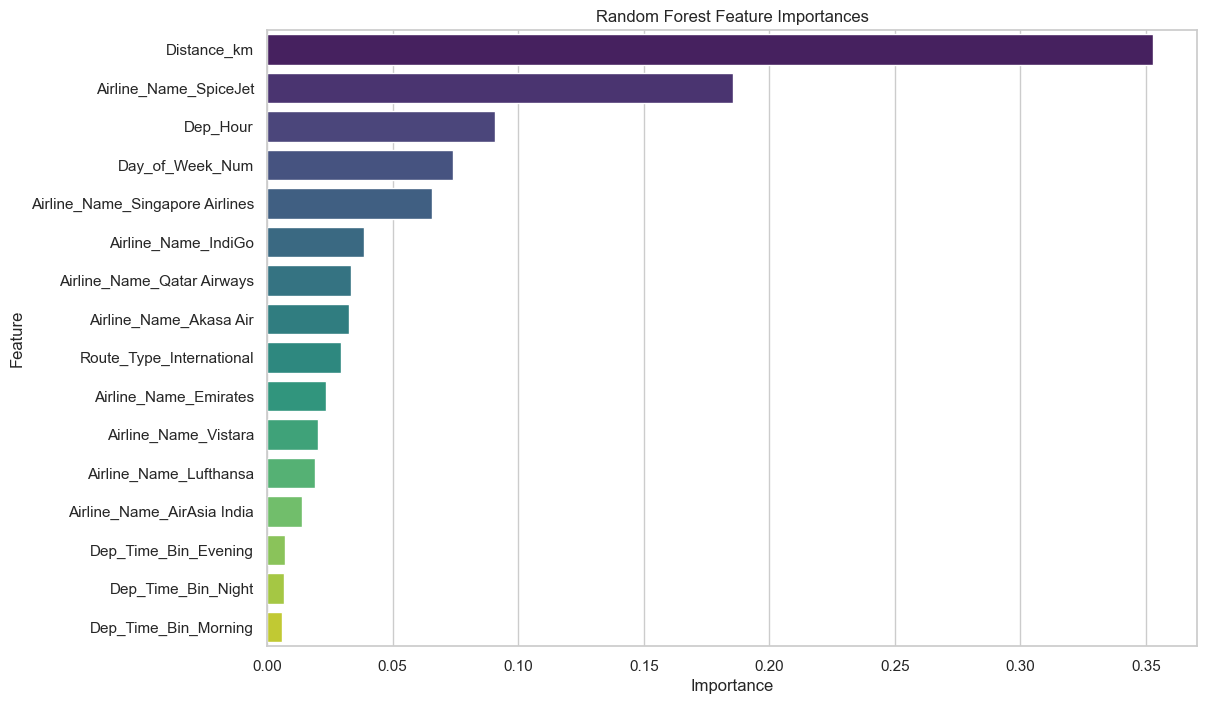

In [92]:
# Step 1: Encode categorical variables
X = flights[feature_cols]
y = flights[target_col]

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=['Airline_Name', 'Route_Type', 'Dep_Time_Bin'], drop_first=True)

# Step 2: Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Train Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Evaluate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Step 5: Feature importance
importances = rf_model.feature_importances_
feature_names = X_encoded.columns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Random Forest Feature Importances")
plt.show()


In [93]:
flights.columns


Index(['Flight_ID', 'Flight_Number', 'Airline_Name', 'Airline_Code', 'Date',
       'Year', 'Month', 'Day_of_Week', 'Source_Airport', 'Destination_Airport',
       'Route_Type', 'Distance_km', 'Flight_Duration_min', 'Departure_Time',
       'Arrival_Time', 'Country_Source', 'Country_Dest', 'Region_Pair',
       'Departure_Time_Bin', 'Departure_Delay_min', 'Arrival_Delay_min',
       'Total_Delay_min', 'Cancelled', 'Cancellation_Reason', 'Fare_Type',
       'Base_Fare_INR', 'Tax_INR', 'Ticket_Price_INR', 'On_Time',
       'Delay_Category', 'Flight_Performance_Score', 'Delayed',
       'Day_of_Week_Num', 'Dep_Hour', 'Dep_Time_Bin', 'Distance_Bucket',
       'Route_Count', 'Is_Weekend'],
      dtype='object')

In [94]:
# ------------------------------------------------------------
# 🔍 CHECK COLUMN NAMES OF ALL CSV FILES (Power BI Project)
# ------------------------------------------------------------

import pandas as pd
import os

# Folder path
folder = "data"   # <-- your folder

# Files inside the folder
files = {
    "flight_level_enriched.csv": os.path.join(folder, "flight_level_enriched.csv"),
    "integrated_routes_final.csv": os.path.join(folder, "integrated_routes_final.csv"),
    "selected_airports.csv": os.path.join(folder, "selected_airports.csv"),
    "airlines_clean.csv": os.path.join(folder, "airlines_clean.csv")
}

print("🔎 Checking Column Names...\n")

for name, path in files.items():
    print(f"📌 File: {name}")
    try:
        df = pd.read_csv(path, nrows=5)  # read first 5 rows
        print("Columns:")
        for col in df.columns:
            print("  -", col)
    except FileNotFoundError:
        print("❌ File not found! Please check the data/ folder.")
    except Exception as e:
        print("⚠ Error while reading file:", e)

    print("\n" + "-"*60 + "\n")


🔎 Checking Column Names...

📌 File: flight_level_enriched.csv
Columns:
  - Flight_ID
  - Flight_Number
  - Airline_Name
  - Airline_Code
  - Date
  - Year
  - Month
  - Day_of_Week
  - Source_Airport
  - Destination_Airport
  - Route_Type
  - Distance_km
  - Flight_Duration_min
  - Departure_Time
  - Arrival_Time
  - Country_Source
  - Country_Dest
  - Region_Pair
  - Departure_Time_Bin
  - Departure_Delay_min
  - Arrival_Delay_min
  - Total_Delay_min
  - Cancelled
  - Cancellation_Reason
  - Fare_Type
  - Base_Fare_INR
  - Tax_INR
  - Ticket_Price_INR
  - On_Time
  - Delay_Category
  - Flight_Performance_Score

------------------------------------------------------------

📌 File: integrated_routes_final.csv
Columns:
  - Source_Airport
  - Destination_Airport
  - Route_Type
  - Latitude_Source
  - Longitude_Source
  - Country_Source
  - Latitude_Dest
  - Longitude_Dest
  - Country_Dest
  - Distance_km
  - Est_Duration_hr
  - Source_in_India
  - Dest_in_India
  - Source_Flight_Frequency